<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Classical Time Series Forecasting Project Template</h1>
</div>

This notebook shows how to implement time series analysis and forecasting algorithms and serve as a template for time series projects. The implementation of techniques you see in this will come handy as a reproducible reference. 

Though this is termed as a 'template', this is meant only to serve as a starting point for the investigator to build his/her analysis on.

### Content:
1. Load the Data
  - Import libraries
  - Load the datasets
  
2. Overview of the Data
  - Descriptive Statistics
  - Missing Values
  
3. Exploratory Data Analysis and Data Preparation
  - Handle the missing values
  - Visualize the time series using line plot
  - Check distribution of the time series
  - Check monthly seasonality using multiple lines
  - Check monthly seasonality and yearly trend using box plot
  - Decompose the time series
  - Stationarity test - Augmented Dickey Fuller test (ADH Test)
  - ACF-PACF plots and Find the order of differencing 
  
4. Model Building
  - Transform the data using box-cox transformation
  - Split data in train-test dataset
  - Model 1 - ARIMA
  - Model 2 - SARIMA
  - Model 3 - SARIMAX
  - Model 4 - Simple Exponential Smoothing
  - Model 5 - Holt-Winters
  - Define function to evaluate models
  - Train and evaluate the model
  - Save the model

## Inputs

The notebook is designed in such a way that you just need to plug in the input values given below and run the code. It will run on it's own and will build the model as well. 

In [64]:
# Input file name with path
input_file_name = 'https://raw.githubusercontent.com/serzaraisk/time_series-template/main/time_series_data.csv'

# Target class name
input_target_variable = 'value'

# Date column name
input_date_variable = 'date'

# Exogenous variable
input_exogenous_variable = 'month_no'

# Handle missing value
input_treat_missing_value = 'interp1d' # choose how to handle missing values from 'ffill','bfill' and 'interp1d'

# Box-cox transformation flag
input_transform_flag = 'Yes' # choose if you wish to transform the data - 'Yes' or 'No'

# Seasonality
input_seasonality = 12
input_order = (0, 1 , 2)
input_seasonal_order = (2, 1, 0, input_seasonality)

# Forecasting algorithm
input_ts_algo = 'auto_sarima' # choose the forecasting algorithm from 'auto_arima', 'auto_sarima', 'auto_sarimax', 'manual_sarima', 'simple_exponential_smoothing' and 'holt_winters'

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Load the Data</h2>
</div>

In this section you will:

- Import the libraries
- Load the dataset

### 1.1. Import Libraries

Import all the libraries in the first cell itself

In [135]:
! pip install pmdarima
! pip install fbprophet

In [140]:
# Import libraries 

# Data Manipulation
import numpy as np 
import pandas as pd
from   pandas import DataFrame
from pandas.plotting import lag_plot

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# Statistics
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from fbprophet import Prophet

from dateutil.parser import parse 
import pickle

from scipy.optimize import minimize  # for function minimization
from tqdm import tqdm_notebook

# Set the options
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)
%matplotlib inline
plt.rcParams.update({'figure.figsize': (12, 8), 'figure.dpi': 120})

In [67]:
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### 1.2. Load the datasets

Load the dataset using pd.read_csv()

In [68]:
# Read data in form of a csv file
df = pd.read_csv(input_file_name)

df[input_date_variable] = pd.to_datetime(df[input_date_variable])

# First 5 rows of the dataset
df.head()

,date,value,month_no
0,1991-07-01,3.526591,7
1,1991-08-01,3.180891,8
2,1991-09-01,3.252221,9
3,1991-10-01,3.611003,10
4,1991-11-01,3.565869,11


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Overview of the Data</h2>
</div>

Before attempting to solve the problem, it's very important to have a good understanding of data.

In this section you will:
- Get the descriptive statistics of the data
- Get the information about missing values in the data

### 2.1. Descriptive Statistics

As the name says descriptive statistics describes the data. It gives you information about
- Mean, median, mode 
- Min, max
- Count etc

Let's understand the data we have

In [69]:
# Dimension of the data
df.shape

(204, 3)

In [70]:
# Summary of the dataset
df.describe()

,value,month_no
count,202.000000,204.000000
mean,10.734642,6.500000
std,5.972693,3.460545
min,2.814520,1.000000
25%,5.821731,3.750000
50%,9.473601,6.500000
75%,14.402814,9.250000
max,29.665356,12.000000


### 2.2. Missing Values

Get the info about missing values in the dataframe

In [71]:
# Missing values for every column
df.isna().sum()

date        0
value       2
month_no    0
dtype: int64

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>3. Exploratory Data Analaysis</h2>
</div>

Exploratory data analysis is an approach to analyze or investigate data sets to find out patterns in the data. Visual methods are often used to summarise the data. Primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing tasks.

In this section you will:
- Handle the missing values
- Visualize the time series using line plot
- Check distribution of the time series
- Check monthly seasonality using multiple lines. Seasonality may be differ for your series.
- Check monthly seasonality and yearly trend using box plot
- Decompose the time series
- Stationarity test - Augmented Dickey Fuller test (ADH Test)
- ACF-PACF plots and Find the order of differencing 

### 3.1. Handle Missing Values

Time Series algorithms doesn't works if the data is missing. So you need to handle the missing values in order to get the predictions

There are various ways to handle missing values for time series data. Some of the ways are:
* forward fill
* Backward Fill
* Linear Interpolation
* Quadratic interpolation
* Mean of nearest neighbors
* Mean of seasonal couterparts

Here you can decide how you want to handle the missing data

In [72]:
# Select how you wish to treat missing values according to the input provided
if input_treat_missing_value == 'ffill':
    
    # forward fill missing values
    df = df.ffill()

elif input_treat_missing_value == 'bfill': 
    
    # backward fill missing values
    df = df.bfill()
    
elif input_treat_missing_value == 'interp1d':
    
    ## Linear Interpolation
    df['rownum'] = np.arange(df.shape[0])
    df_nona = df.dropna(subset = ['value'])
    f = interp1d(df_nona['rownum'], df_nona['value'])
    df[input_target_variable] = f(df['rownum'])
    df = df.drop('rownum', axis = 1)

elif input_treat_missing_value == 'interp2d':
    
    ## Linear Interpolation
    df['rownum'] = np.arange(df.shape[0])
    df_nona = df.dropna(subset = ['value'])
    f = interp1d(df_nona['rownum'], df_nona['value'], kind='cubic')
    df[input_target_variable] = f(df['rownum'])
    df = df.drop('rownum', axis = 1)

In [73]:
df.head()

,date,value,month_no
0,1991-07-01,3.526591,7
1,1991-08-01,3.180891,8
2,1991-09-01,3.252221,9
3,1991-10-01,3.611003,10
4,1991-11-01,3.565869,11


### 3.2. Visualize the time series using line plot

A line plot of a time series can provide a lot of insight into the problem. Some observations from the plot can include:
- Whether the trend appears to be level around the mean
- Whether there appear to be any obvious outliers

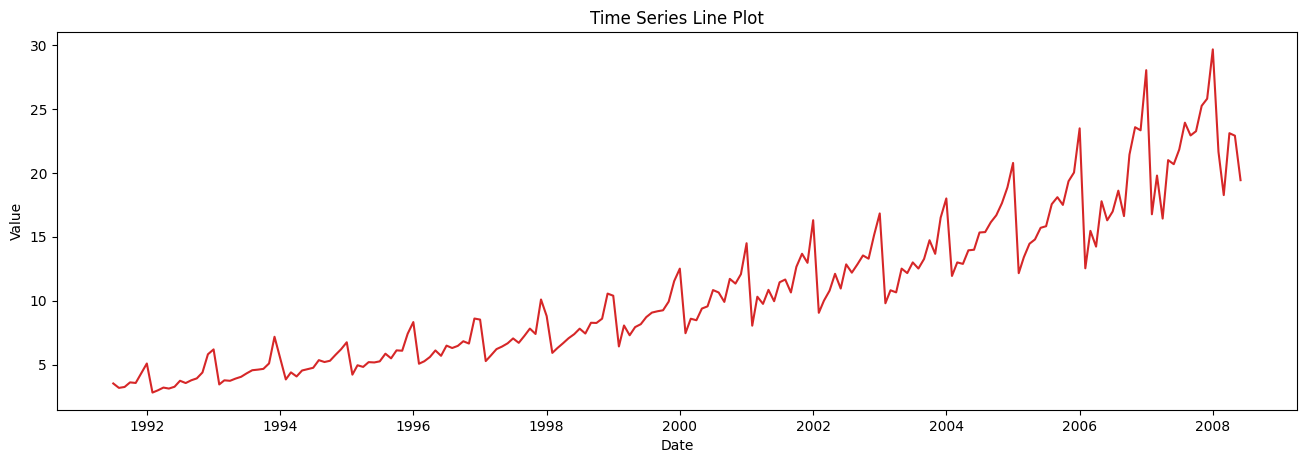

In [74]:
# Draw line Plot
def plot_df(x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(x=df[input_date_variable], y=df[input_target_variable], title='Time Series Line Plot')

If all the values are positive, you can use the below chart to emphasize the growth.

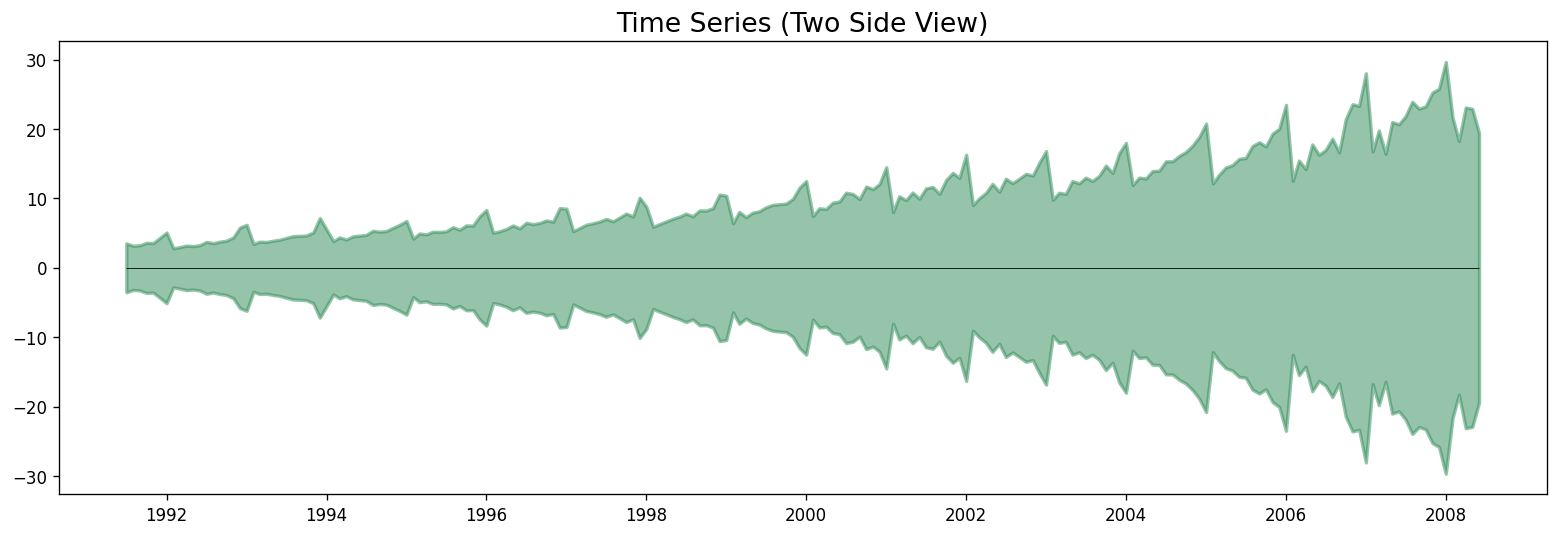

In [75]:
# Draw plot
x = df[input_date_variable]
y1 = df[input_target_variable].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.title('Time Series (Two Side View)', fontsize=16)
plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
plt.show()

### 3.3. Check distribution of the time series

You should check the distribution of the time series so that you can decide if you need to transform the data or can be used as it is. Additionally, it provides insights about the type of distribution the data follows

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


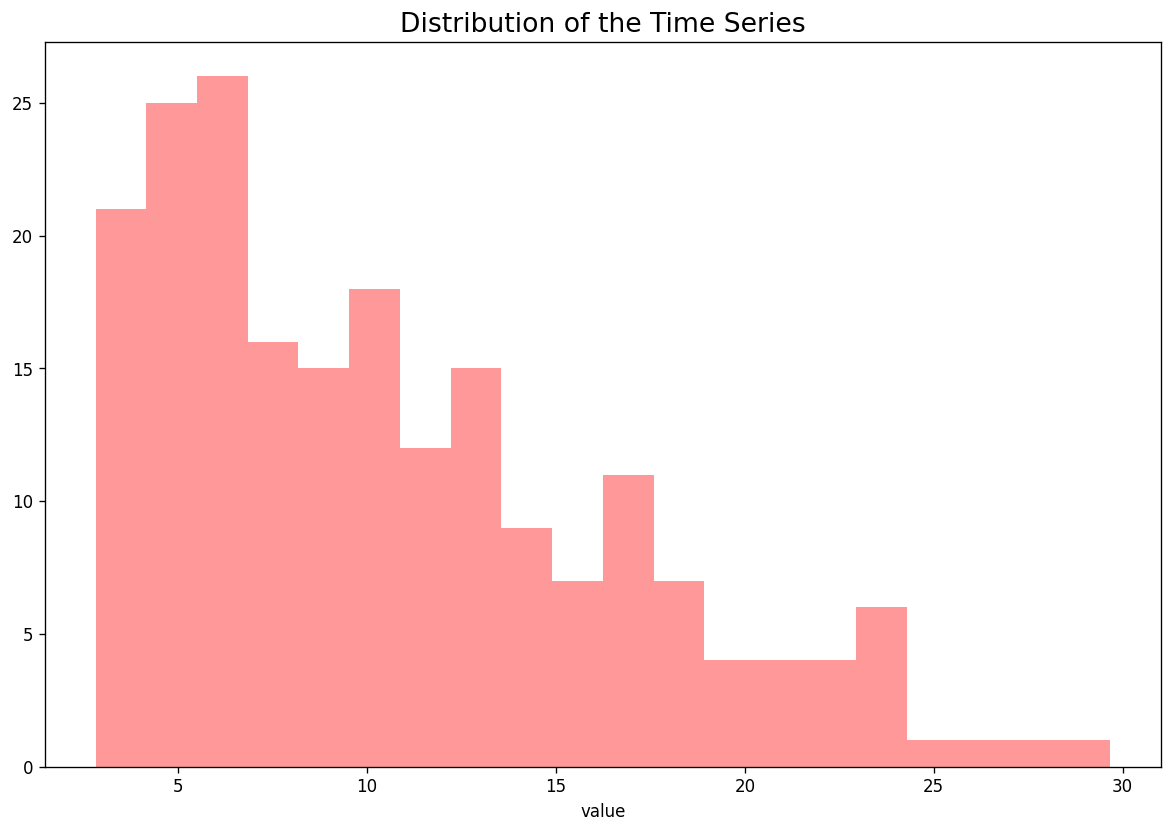

In [76]:
sns.distplot(df[input_target_variable], kde = False, color ='red', bins = 20)
plt.title('Distribution of the Time Series', fontsize=16)
plt.show()

### 3.4. Check monthly seasonality using multiple lines

You can check if the data follows a certain repetitive pattern every year. You can plot each year as a separate line in the same plot. This lets you compare the year wise patterns side-by-side.


This step is applicable for monthly time series. If you have another time series, you can change it to weekly or quaterly or half yearly etc.

In [77]:
def plot_timeseries_divided(df, target_series_name, devided_series_name,  x_series_name, title):

    periods = df[devided_series_name].unique()

    # Prep Colors
    np.random.seed(100)
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(periods), replace=False)

    # Draw Plot
    plt.figure(figsize=(16,8), dpi= 80)
    for i, y in enumerate(periods):
        if i>0:
            plt.plot(x_series_name, target_series_name, data=df.loc[df[devided_series_name]==y, :], color=mycolors[i], label=y)
            plt.text(df.loc[df[devided_series_name]==y, :].shape[0]-.9, df.loc[df[devided_series_name]==y, target_series_name][-1:].values[0], y, fontsize=12, color=mycolors[i])

    # Decoration
    plt.gca().set(ylabel=target_series_name, xlabel=x_series_name)
    num_ticks=len(df[x_series_name].unique())
    plt.yticks(fontsize=10, alpha=.7)
    plt.title(title, fontsize=20)
    plt.show()

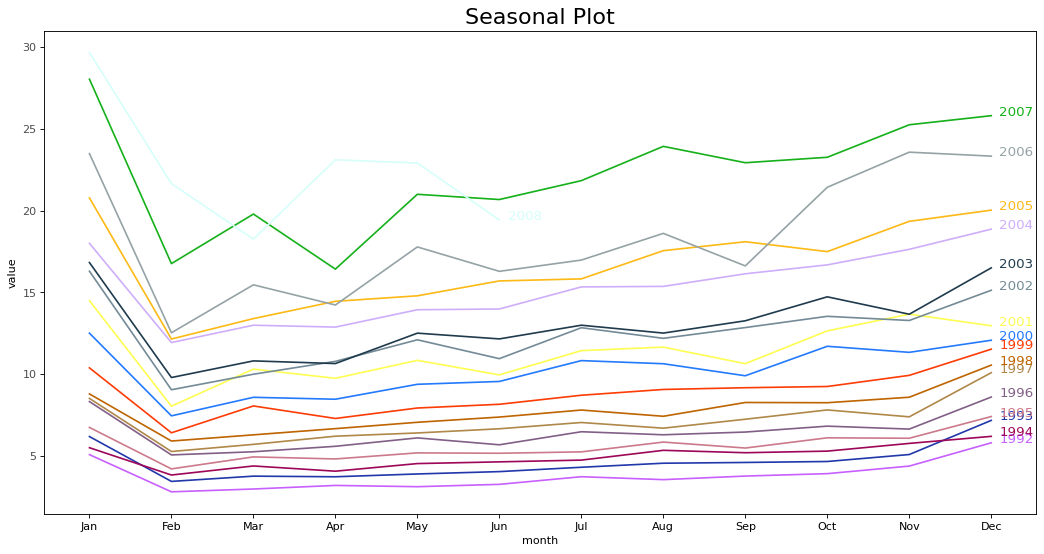

In [78]:
df['year'] = [d.year for d in df[input_date_variable]]
df['month'] = [d.strftime('%b') for d in df[input_date_variable]]
plot_timeseries_divided(df, input_target_variable, 'year', 'month', 'Seasonal Plot')

### 3.5. Plot moving average with confidence intervals

In [79]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


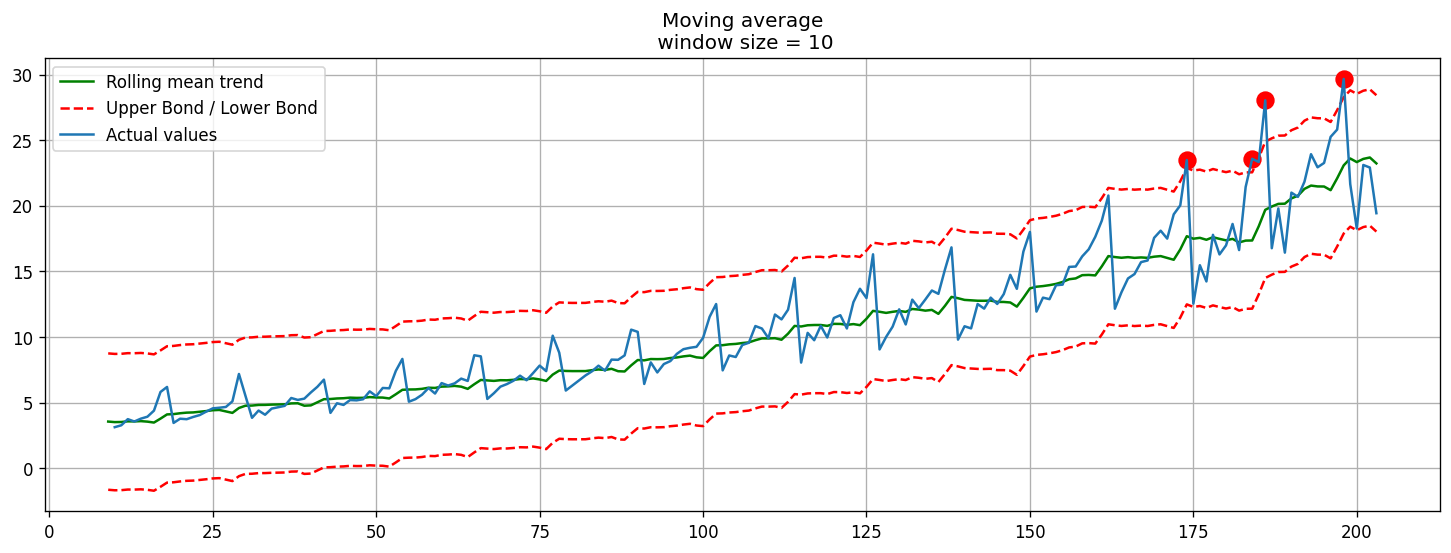

In [80]:
plotMovingAverage(df[['value']], 10, plot_intervals=True, plot_anomalies=True)

### 3.6. Plot exponential smoothing 


$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Here the model value is a weighted average between the current true value and the previous model values. The $\alpha$ weight is called a smoothing factor. It defines how quickly we will "forget" the last available true observation. The smaller $\alpha$ is, the more influence the previous observations have and the smoother the series is.

Exponentiality is hidden in the recursiveness of the function – we multiply by $(1-\alpha)$ each time, which already contains a multiplication by $(1-\alpha)$ of previous model values.

In [81]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [82]:
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

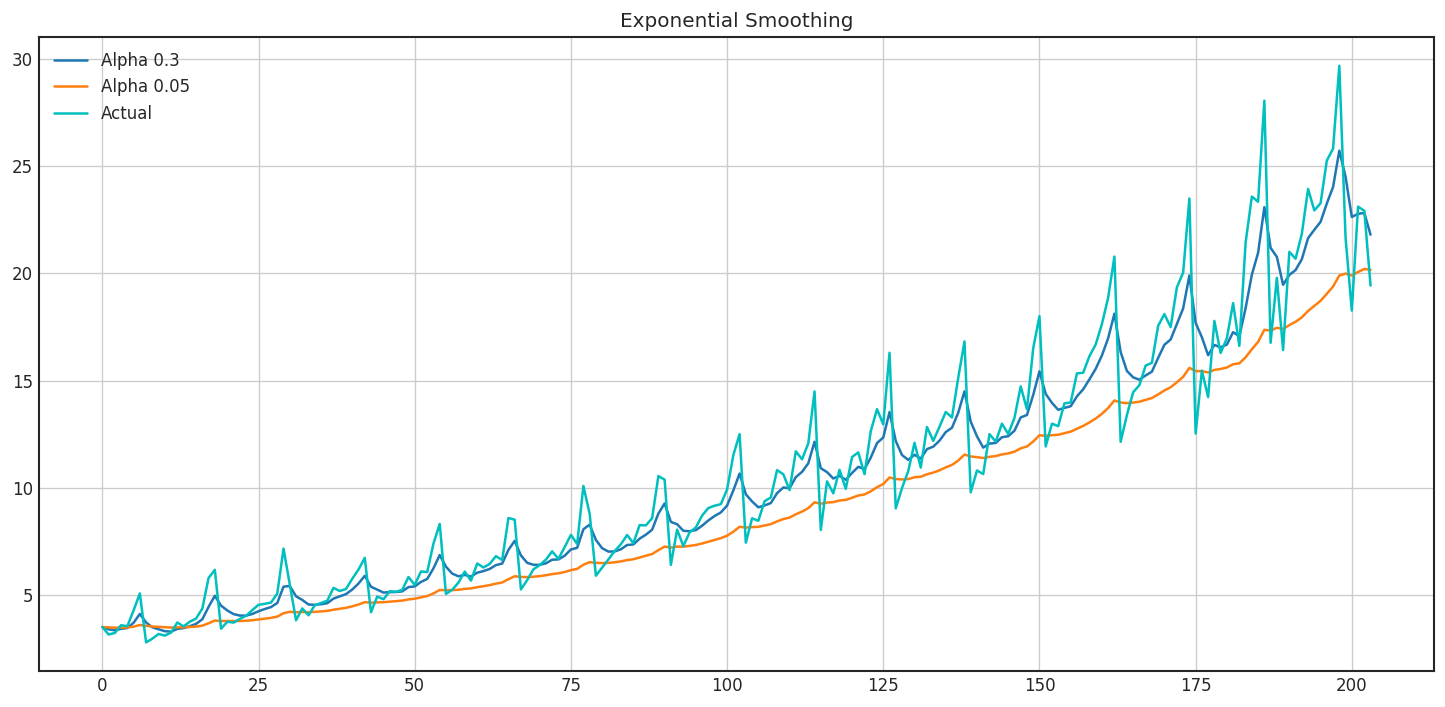

In [83]:
plotExponentialSmoothing(df[input_target_variable], [0.3, 0.05])

### 3.7. Plot double exponential smooting

Series decomposition will help us -- we obtain two components: intercept (i.e. level) $\ell$ and slope (i.e. trend) $b$. We have learnt to predict intercept (or expected series value) with our previous methods; now, we will apply the same exponential smoothing to the trend by assuming that the future direction of the time series changes depends on the previous weighted changes. As a result, we get the following set of functions:

$$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$\hat{y}_{x+1} = \ell_x + b_x$$

The first one describes the intercept, which, as before, depends on the current value of the series. The second term is now split into previous values of the level and of the trend. The second function describes the trend, which depends on the level changes at the current step and on the previous value of the trend. In this case, the $\beta$ coefficient is a weight for exponential smoothing. The final prediction is the sum of the model values of the intercept and trend.

In [84]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series) + 1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):  # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result


def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """

    with plt.style.context("seaborn-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(
                    double_exponential_smoothing(series, alpha, beta),
                    label="Alpha {}, beta {}".format(alpha, beta),
                )
        plt.plot(series.values, label="Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

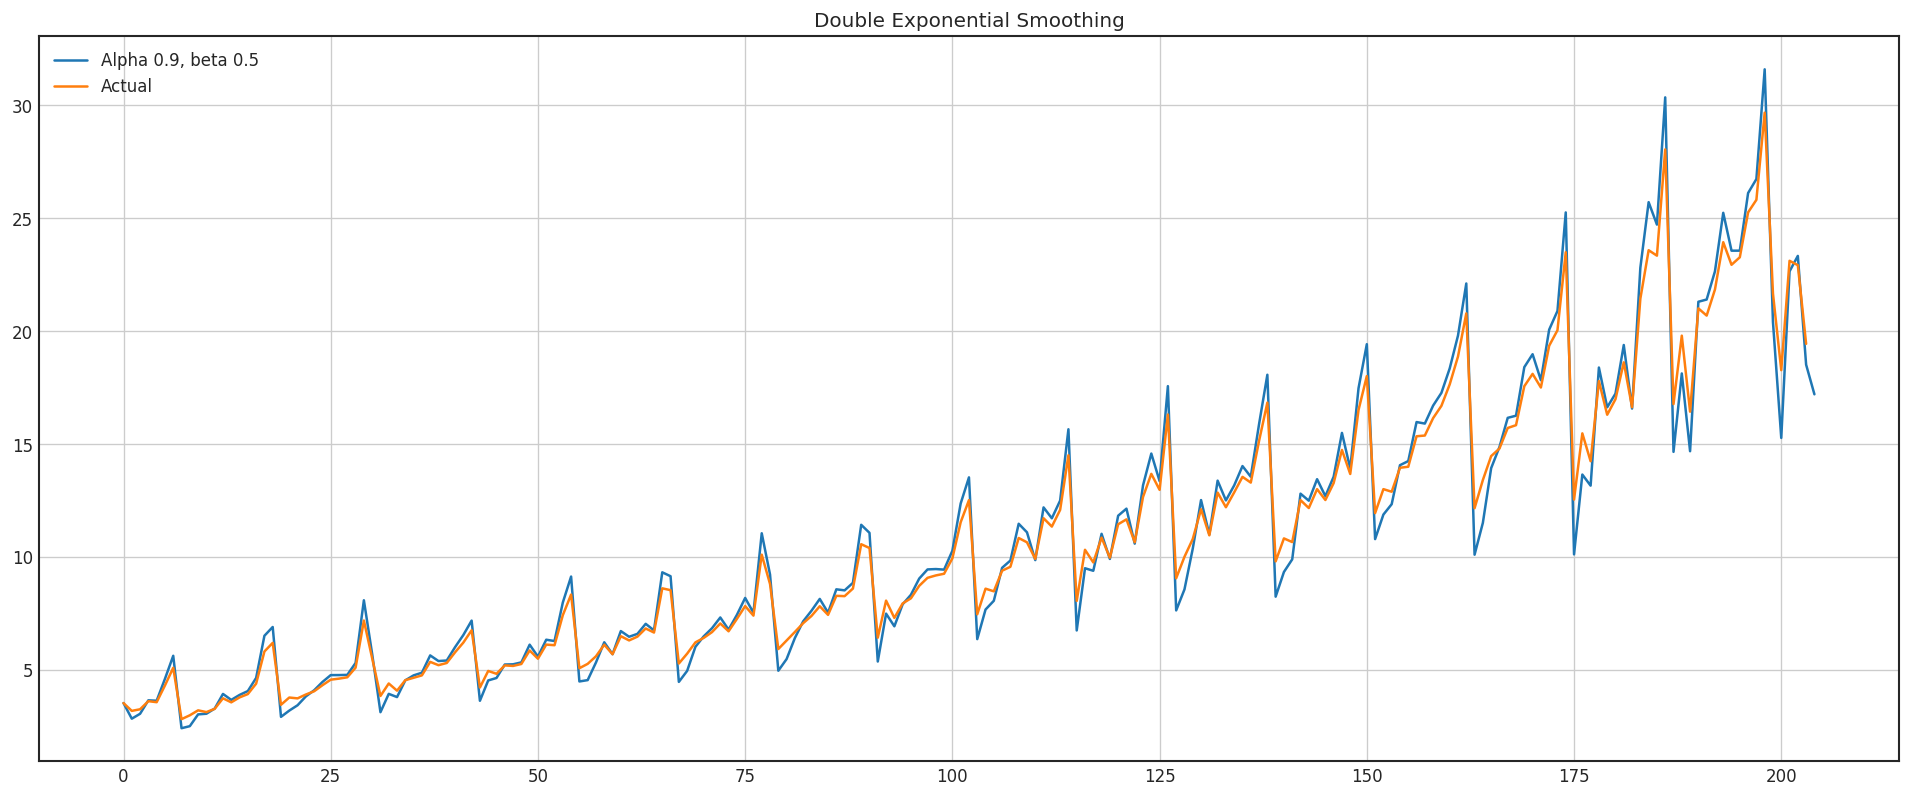

In [85]:
plotDoubleExponentialSmoothing(df[input_target_variable], alphas=[0.9], betas=[0.5])

### 3.8. Holt-Winters triple exponential smoothing and detect anomalies

We've looked at exponential smoothing and double exponential smoothing. This time, we're going into _triple_ exponential smoothing.

As you could have guessed, the idea is to add a third component - seasonality. This means that we should not use this method if our time series is not expected to have seasonality. Seasonal components in the model will explain repeated variations around intercept and trend, and it will be specified by the length of the season, in other words by the period after which the variations repeat. For each observation in the season, there is a separate component; for example, if the length of the season is 7 days (a weekly seasonality), we will have 7 seasonal components, one for each day of the week.

With this, let's write out a new system of equations:

$$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$$

$$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$$

$$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$$

$$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$$

The intercept now depends on the current value of the series minus any corresponding seasonal component. Trend remains unchanged, and the seasonal component depends on the current value of the series minus the intercept and on the previous value of the component. Take into account that the component is smoothed through all the available seasons; for example, if we have a Monday component, then it will only be averaged with other Mondays. You can read more on how averaging works and how the initial approximation of the trend and seasonal components is done [here](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Now that we have the seasonal component, we can predict not just one or two steps ahead but an arbitrary $m$ future steps ahead, which is very encouraging.

Below is the code for a triple exponential smoothing model, which is also known by the last names of its creators, Charles Holt and his student Peter Winters. Additionally, the Brutlag method was included in the model to produce confidence intervals:

$$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$$

$$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$$

$$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T},$$

where $T$ is the length of the season, $d$ is the predicted deviation. Other parameters were taken from triple exponential smoothing. You can read more about the method and its applicability to anomaly detection in time series [here](http://fedcsis.org/proceedings/2012/pliks/118.pdf).

In [86]:
class HoltWinters:

    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i + self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series) / self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(
                sum(self.series[self.slen * j : self.slen * j + self.slen])
                / float(self.slen)
            )
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += (
                    self.series[self.slen * j + i] - season_averages[j]
                )
            seasonals[i] = sum_of_vals_over_avg / n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series) + self.n_preds):
            if i == 0:  # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(
                    self.result[0] + self.scaling_factor * self.PredictedDeviation[0]
                )

                self.LowerBond.append(
                    self.result[0] - self.scaling_factor * self.PredictedDeviation[0]
                )
                continue

            if i >= len(self.series):  # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m * trend) + seasonals[i % self.slen])

                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1] * 1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = (
                    smooth,
                    self.alpha * (val - seasonals[i % self.slen])
                    + (1 - self.alpha) * (smooth + trend),
                )
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = (
                    self.gamma * (val - smooth)
                    + (1 - self.gamma) * seasonals[i % self.slen]
                )
                self.result.append(smooth + trend + seasonals[i % self.slen])

                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i])
                    + (1 - self.gamma) * self.PredictedDeviation[-1]
                )

            self.UpperBond.append(
                self.result[-1] + self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.LowerBond.append(
                self.result[-1] - self.scaling_factor * self.PredictedDeviation[-1]
            )

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [87]:
from sklearn.model_selection import \
    TimeSeriesSplit  # you have everything done for you


def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []

    values = series.values
    alpha, beta, gamma = params

    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3)

    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(
            series=values[train],
            slen=slen,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            n_preds=len(test),
        )
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test) :]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)

    return np.mean(np.array(errors))

In [88]:
%%time
data = df[input_target_variable][:-10]  # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0]

# Minimizing the loss function
opt = minimize(
    timeseriesCVscore,
    x0=x,
    args=(data, mean_squared_log_error),
    method="TNC",
    bounds=((0, 1), (0, 1), (0, 1)),
)

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(
    data,
    slen=12,
    alpha=alpha_final,
    beta=beta_final,
    gamma=gamma_final,
    n_preds=20,
    scaling_factor=3,
)
model.triple_exponential_smoothing()

0.011158582040150467 0.22077759509375755 0.4242355524052548
CPU times: user 2.3 s, sys: 64.6 ms, total: 2.36 s
Wall time: 2.28 s


In [89]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

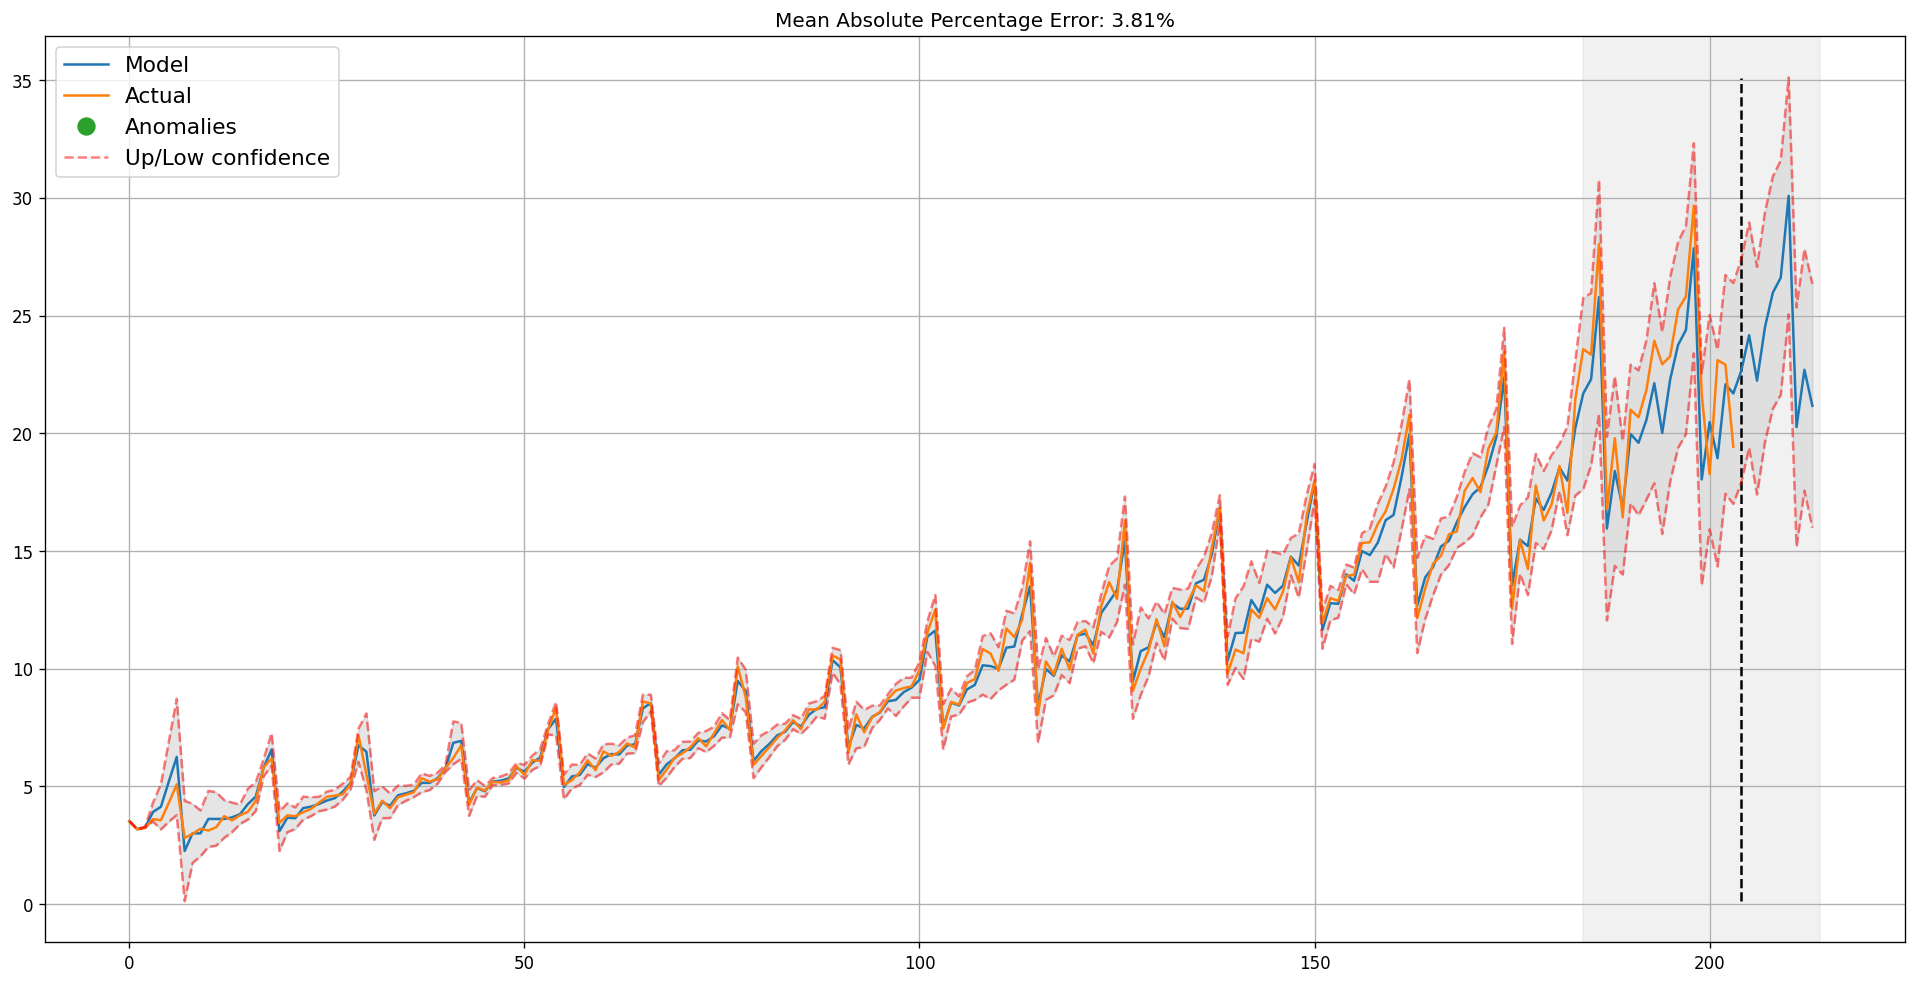

In [90]:
plotHoltWinters(df[input_target_variable], plot_intervals=True, plot_anomalies=True)

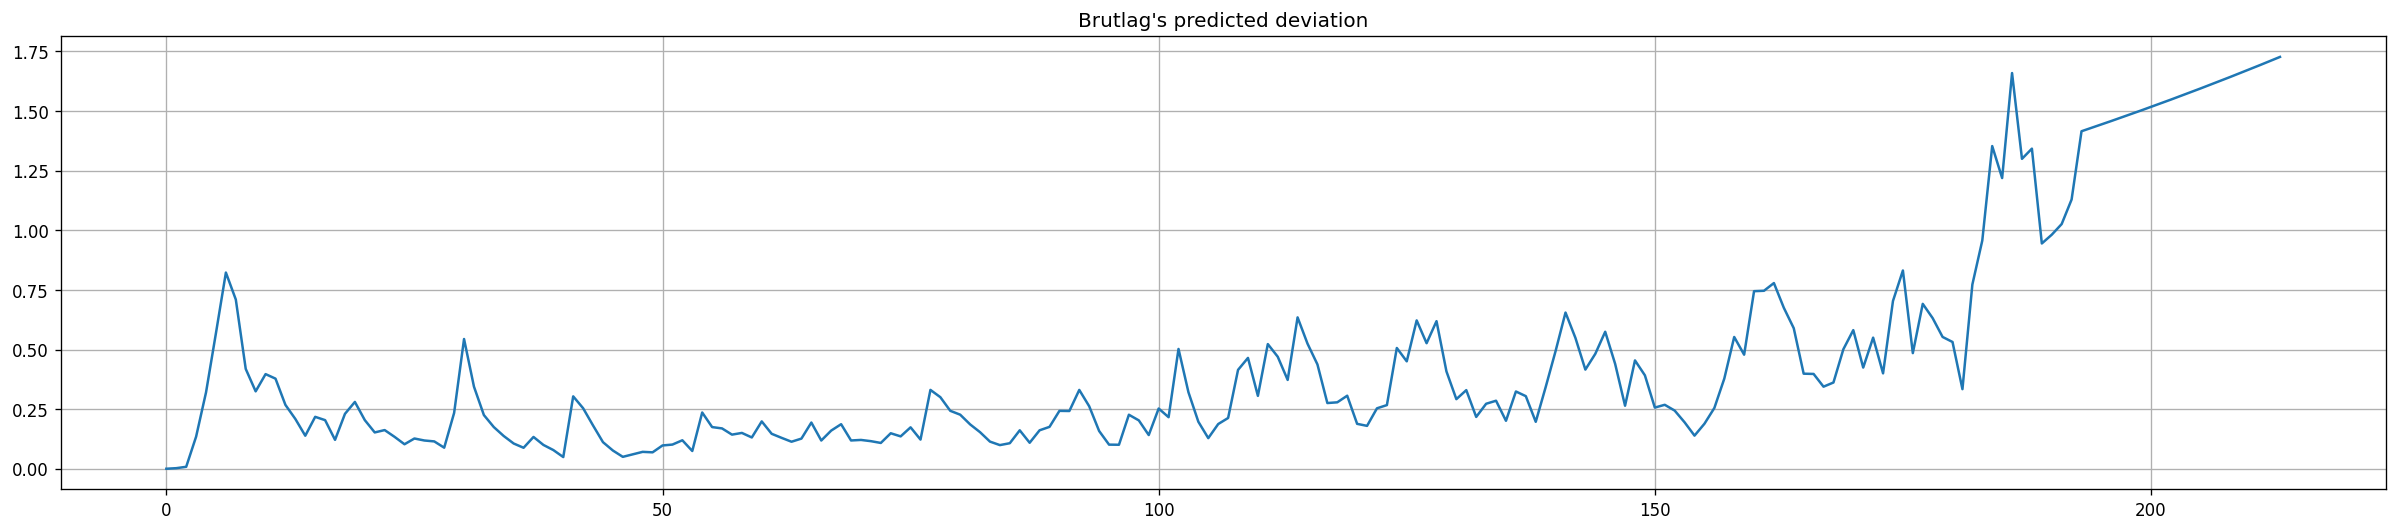

In [91]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

### 3.6. Seasonality and Yearly Trend using Box Plot

You can check the yearly trend and monthly seasonality using a box plot.

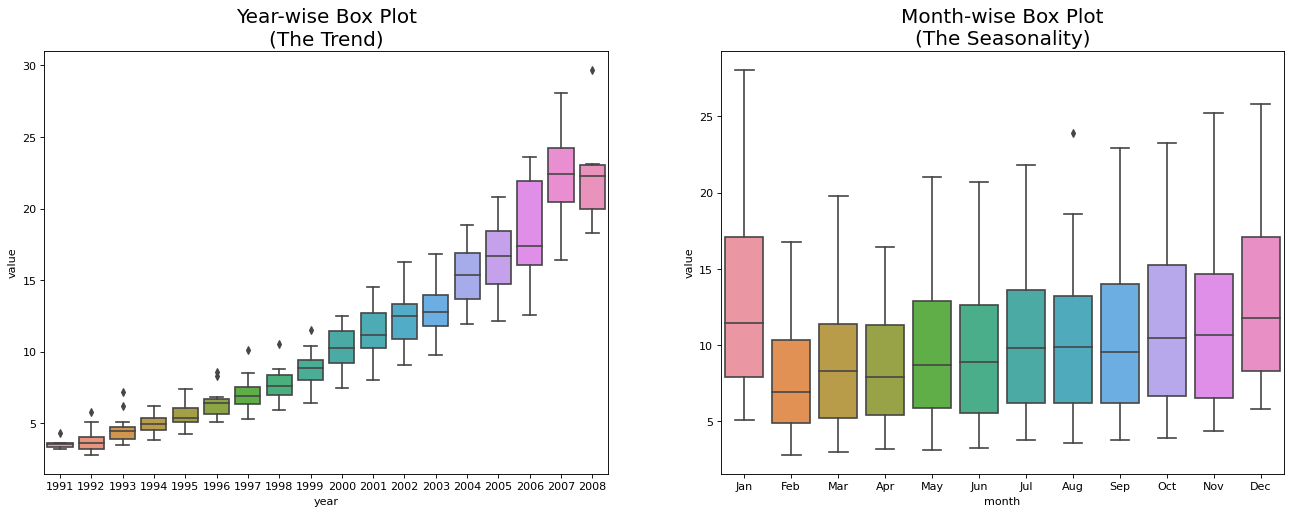

In [92]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y=input_target_variable, data=df, ax=axes[0])
sns.boxplot(x='month', y=input_target_variable, data=df.loc[~df.year.isin([1991, 2008]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### 3.7. Time Series Decomposition

Depending on the nature of the trend and seasonality, a time series can be modeled as an additive or multiplicative, wherein, each observation in the series can be expressed as either a sum or a product of the components:

Additive time series:
- Value = Base Level + Trend + Seasonality + Error

Multiplicative Time Series:
- Value = Base Level x Trend x Seasonality x Error

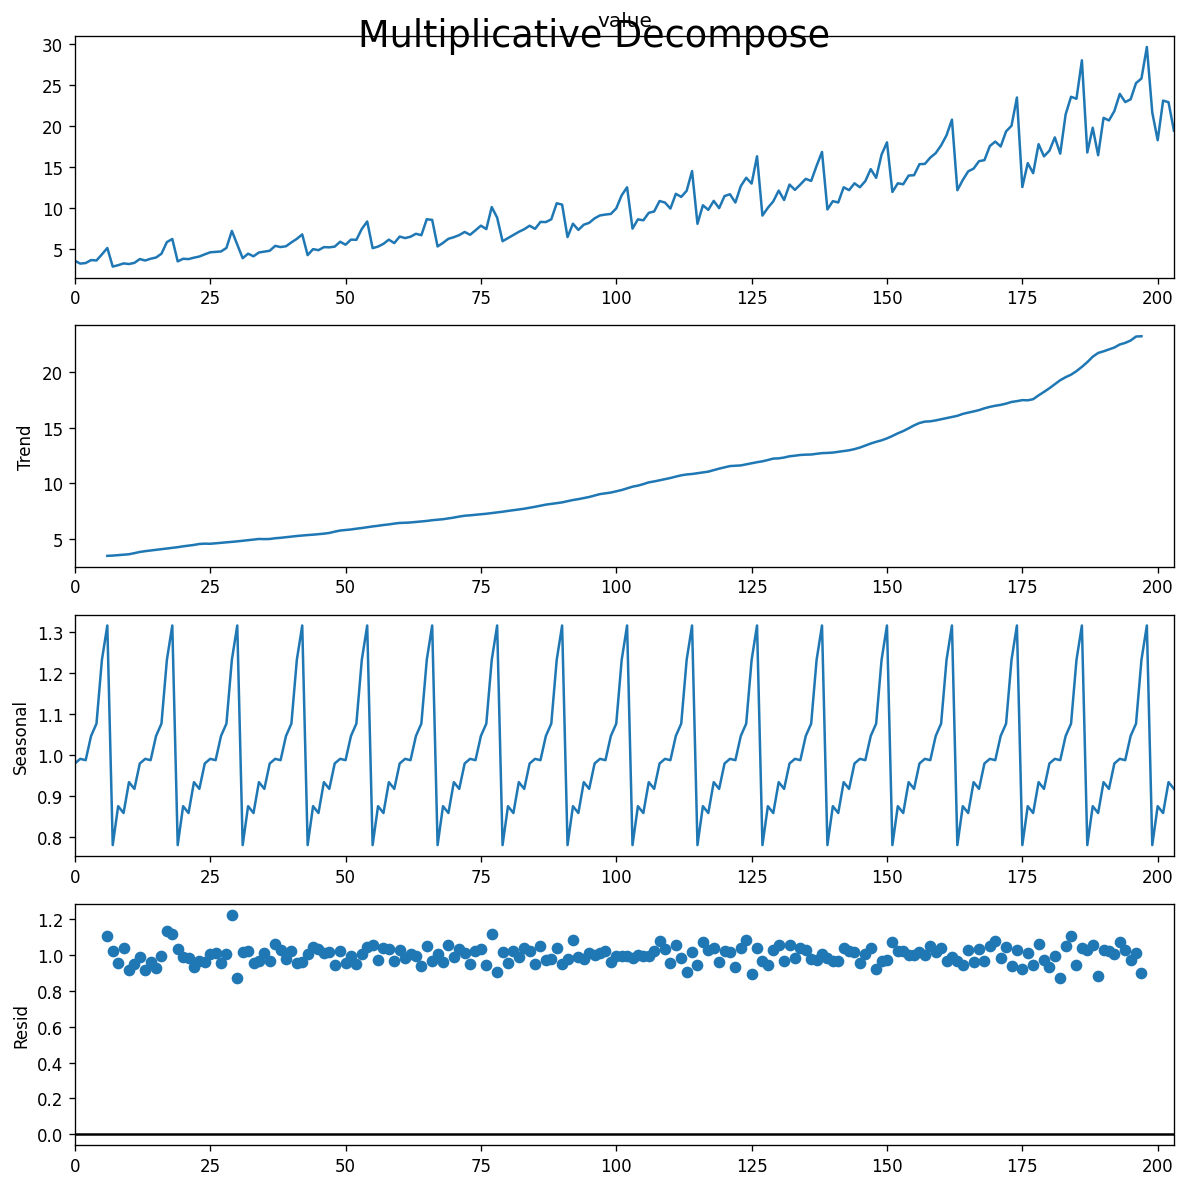

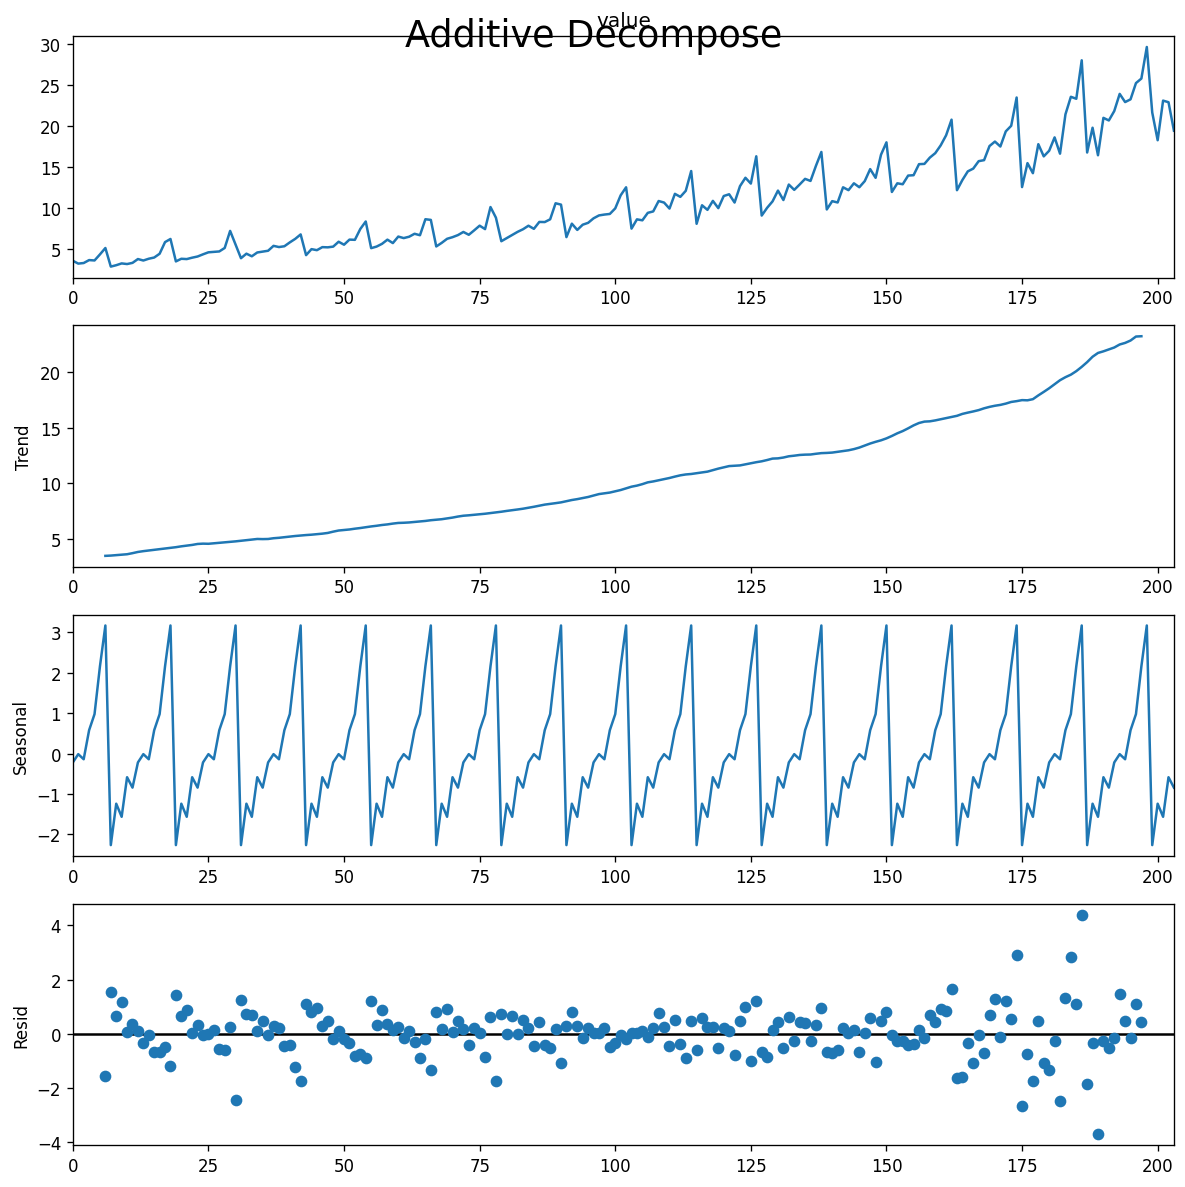

In [93]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df[input_target_variable], model='multiplicative', period=input_seasonality)

# Additive Decomposition
result_add = seasonal_decompose(df[input_target_variable], model='additive', period=input_seasonality)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [94]:
# Extract the Components ----
# Actual Values = Summation of (Seasonal + Trend + Resid)
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed.head(10)

,seas,trend,resid,actual_values
0,-0.220214,NaN,NaN,3.526591
1,-0.015521,NaN,NaN,3.180891
2,-0.141426,NaN,NaN,3.252221
3,0.576757,NaN,NaN,3.611003
4,0.974431,NaN,NaN,3.565869
5,2.157772,NaN,NaN,4.306371
6,3.166417,3.503344,-1.581426,5.088335
7,-2.264404,3.527891,1.551033,2.814520
8,-1.241074,3.565511,0.661374,2.985811
9,-1.563869,3.600447,1.168202,3.204780


In [95]:
df.trend = df_reconstructed.trend

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


#### How to detrend a time series?
1. Subtract the line of best fit from the time series. The line of best fit may be obtained from a linear regression model with the time steps as the predictor. For more complex trends, you may want to use quadratic terms (x^2) in the model.
Subtract the trend component obtained from time series decomposition we saw earlier.

2. Subtract the mean

3. Apply a filter like Baxter-King filter(statsmodels.tsa.filters.bkfilter) or the Hodrick-Prescott Filter (statsmodels.tsa.filters.hpfilter) to remove the moving average trend lines or the cyclical components.

#### How to deseasonalize a time series?
1. Take a moving average with length as the seasonal window. This will smoothen in series in the process.

2. Seasonal difference the series (subtract the value of previous season from the current value)

3. Divide the series by the seasonal index obtained from STL decomposition

### 3.8. Stationarity test - Augmented Dickey Fuller test (ADH Test)

There are mulitple tests to test if a time series is stationary or not.

The most commonly used is the ADF test, where the null hypothesis is the time series possesses a unit root and is non-stationary. So, id the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis.

The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python.

In [96]:
# ADF Test
result = adfuller(df[input_target_variable].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: 3.150086762069155
p-value: 1.0
Critial Values:
   1%, -3.465620397124192
Critial Values:
   5%, -2.8770397560752436
Critial Values:
   10%, -2.5750324547306476


In [97]:
# KPSS Test
result = kpss(df.value.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.314030
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


### 3.9. ACF-PACF plots and Find the order of differencing 

**How to find the order of differencing?**

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.

In [98]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

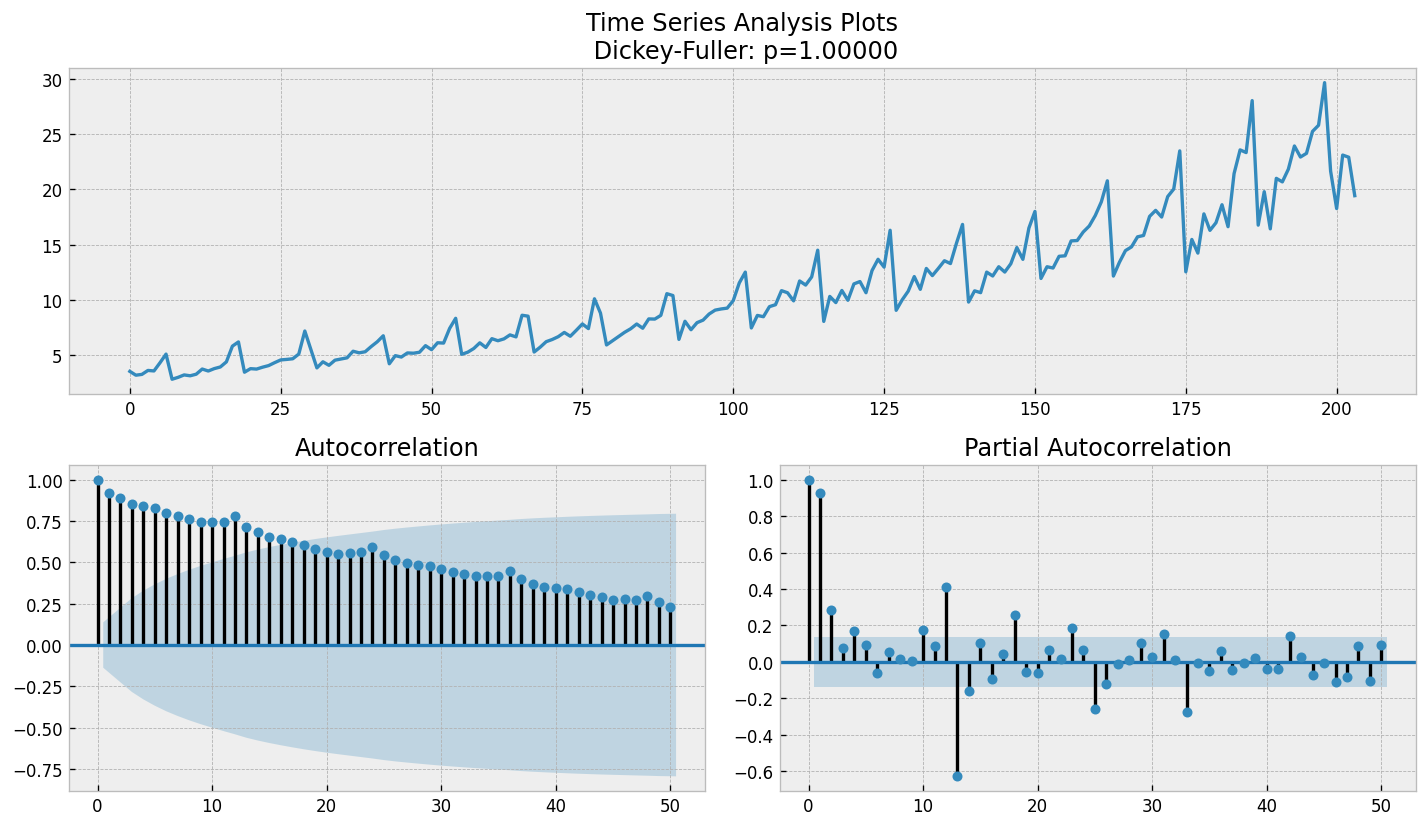

In [99]:
tsplot(df[input_target_variable], lags=50)

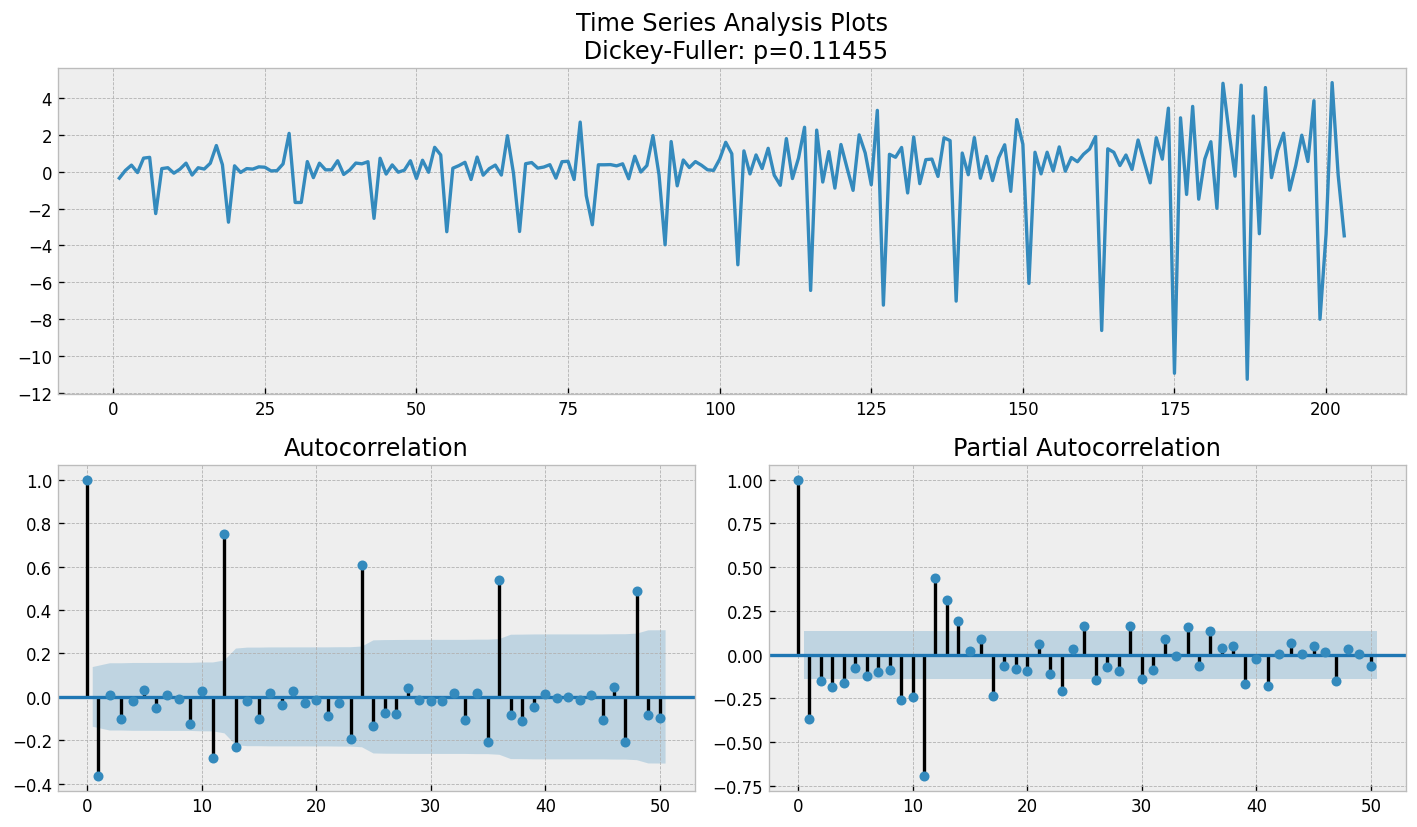

In [100]:
tsplot(df[input_target_variable].diff().dropna(), lags=50)

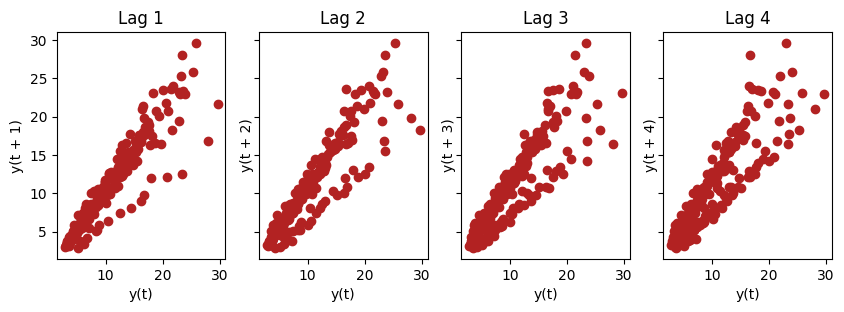

In [101]:
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df[input_target_variable], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

In [102]:
## Adf Test
print('Adf Test: ', ndiffs(df[input_target_variable], test='adf'))
# KPSS test
print('KPSS test: ', ndiffs(df[input_target_variable], test='kpss')) 
# PP test:
print('PP test: ', ndiffs(df[input_target_variable], test='pp'))

Adf Test:  0
KPSS test:  1
PP test:  0


If your series is slightly under differenced, adding one or more additional AR terms usually makes it up. Likewise, if it is slightly over-differenced, try adding an additional MA term.

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Model Building</h2>
</div>

In this section you will:
- Transform the data using box-cox transformation
- Split data in train-test dataset
- Model 1 - ARIMA
- Model 2 - SARIMA
- Model 3 - SARIMAX
- Model 4 - Simple Exponential Smoothing
- Model 5 - Holt-Winters
- Define function to evaluate models
- Train and evaluate the model
- Save the model

### 4.1. Box-Cox Tranformation

Transform the data to be normally distributed

In [103]:
df.head()

,date,value,month_no,year,month
0,1991-07-01,3.526591,7,1991,Jul
1,1991-08-01,3.180891,8,1991,Aug
2,1991-09-01,3.252221,9,1991,Sep
3,1991-10-01,3.611003,10,1991,Oct
4,1991-11-01,3.565869,11,1991,Nov


In [104]:
# Box - Cox Transform
if input_transform_flag == 'Yes':
    df[input_target_variable], lam = boxcox(df[input_target_variable])
else:
    print("No transformation")

In [105]:
df.head()

,date,value,month_no,year,month
0,1991-07-01,1.308054,7,1991,Jul
1,1991-08-01,1.197308,8,1991,Aug
2,1991-09-01,1.221057,9,1991,Sep
3,1991-10-01,1.333539,10,1991,Oct
4,1991-11-01,1.319983,11,1991,Nov


### 4.2. Train - Test Window Split

Split the dataset in training and test set

In [106]:
train_pct = 0.80
train_size = int(len(df) * train_pct)
test_size = len(df) - train_size
train, test = df[0:train_size], df[train_size:]

### 4.3. Model 1 - ARIMA

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

The initial order of the ARIMA model can be determined using the the ACF and PACF plots. The initial starting point for 'p' is the number of significant lags from the PACF plot and 'q' comes from the number of significant lags from the ACF plot.

You might want to check the error for serial correlation using the Durbin-Watson statistic and ch

I will demonstrate the code in upcoming section.

### 4.4. Model 2 - SARIMA

If a time series has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for ‘Seasonal ARIMA’.

I will demonstrate the code in next section

### 4.5. Model 3 - SARIMAX

If a time series has seasonal patterns and an external predictor (also called as exogenous variable), then you need to add seasonal and exogenous terms and it becomes SARIMAX

The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

Since ARIMA, SARIMA and SARIMAX are from the same family. I have defined a single function to fit these models automatically.

In [107]:
def model_auto_sarimax(y, seasonality, seasonal_flag, exogenous_variable):
    
    # Train model
    model = pm.auto_arima(train[input_target_variable], exogenous=exogenous_variable, 
                          start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = input_seasonality, 
                          start_P = 0, seasonal = True, 
                          d = None, max_D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  stepwise = True, 
                          max_order=12)
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

You can fit in the parameters manually as well. 

In [108]:
def model_manual_sarima(y, order, seasonal_order):
    
    # Train model
    model = SARIMAX(y, order = order, seasonal_order = seasonal_order).fit()
    
    # Model summary 
    print(model.summary())
    
    # Model diagnostics
    model.plot_diagnostics(figsize=(10,7))
    plt.show()
    
    return model

### 4.6. Model 4 - Simple Exponential Smoothing

Single Exponential Smoothing is a time series forecasting algorithm for univariate data which doesn't have a trend or seasonality. Only one parameter is required for SES - alpha (a).  It is the smoothing coefficient.

In [109]:
def model_simple_exponential_smoothing(y):
    
    # Train model
    model = SimpleExpSmoothing(np.asarray(y)).fit(smoothing_level=0.6,optimized=False)
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.7. Model 5 - Holt-Winters

Holt-Winters is a time series forecasting algorithm. It models three aspects of the time series: a typical value (average), a slope (trend) over time, and a cyclical repeating pattern (seasonality).

You need to pass on the parameter seasonality to it

In [110]:
def model_holt_winters(y, seasonality):
    
    # Train model
    model = ExponentialSmoothing(np.asarray(y) ,seasonal_periods=seasonality ,trend='add', seasonal='add',).fit()
    
    # Model summary 
    print(model.summary())
    
    return model

### 4.8. Define function to get the predictions

In [111]:
def get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None):
    
    print("------------- Get Predictions --------------- \n")
    # Get prediction for test duration
    if input_ts_algo == "manual_sarima":
        predictions = pd.Series(model.predict(len(train) + 1, len(train) + len(test), typ = 'levels').rename("Predictions")).reset_index(drop = True)
    elif input_ts_algo in ["auto_arima", "auto_sarima", "auto_sarimax"]:
        predictions = pd.Series(model.predict(len(test), exogenous = exogenous_variable)).reset_index(drop = True)
    else:
        predictions = pd.Series(model.forecast(len(test))).reset_index(drop = True)
    return predictions

### 4.9. Define function to evaluate models

- Durbin Watson Statistic
- MAPE
- MAE
- RSME
- R2 Score

In [112]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [113]:
def durbin_watson_stat(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    return(durbin_watson(validation_df.error))

In [114]:
def analyse_error(actuals, predictions):
    validation_df = pd.DataFrame({"actual" : actuals, "prediction" : predictions})
    validation_df["error"] = validation_df.actual - validation_df.prediction
    
    plt.scatter(validation_df.actual, validation_df.error)
    plt.xlabel("Actual")
    plt.ylabel("Errors")
    plt.title('Residual Error Analysis')
    plt.show()

In [115]:
def evaluate_model(actuals, predictions, input_target_variable = input_target_variable):
    
    print("------------- Model Evaluations --------------- \n")
    
    print("MAPE : ", mean_absolute_percentage_error(actuals, predictions))
    print("MAE  : ", mean_absolute_error(actuals, predictions))
    print("RMSE  : ", mean_squared_error(actuals, predictions, squared=False))
    print("R2 Score  : ", r2_score(actuals, predictions))
    print("Durbin Watson Score : ", durbin_watson_stat(actuals, predictions))
    
    analyse_error(actuals, predictions)
    
    # Plot actual vs predicted
    predictions.plot(legend = True, label = "Prediction", xlabel = "Index", ylabel = input_target_variable,  figsize=(10, 7)) 
    actuals.plot(legend = True, label = "Actual");
    plt.title("Actual vs Predicted", fontsize = 12)

### 4.10. Train and evaluate the model

------------- Auto SARIMA --------------- 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-62.921, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-64.277, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-277.543, Time=0.35 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-291.270, Time=0.64 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-170.108, Time=0.22 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.91 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=-228.456, Time=0.83 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=-292.708, Time=2.20 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.92 sec
 ARIMA(0,1,1

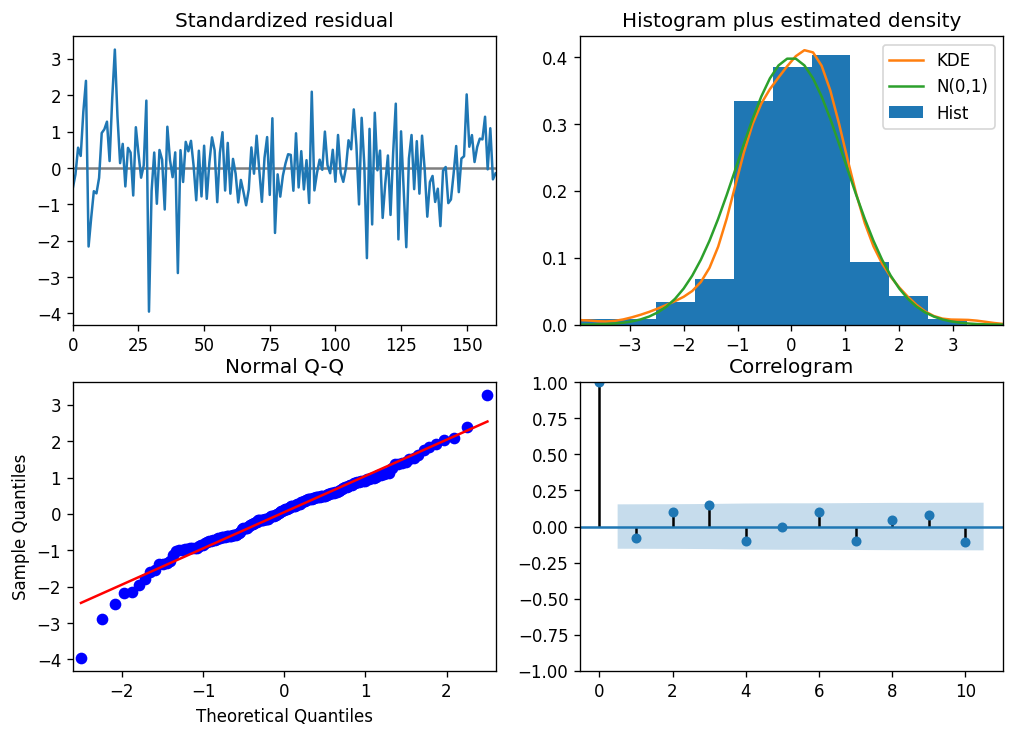

------------- Get Predictions --------------- 

------------- Model Evaluations --------------- 

MAPE :  2.498752175232907
MAE  :  0.07864725761502148
RMSE  :  0.09755587955997835
R2 Score  :  0.8524096076845884
Durbin Watson Score :  1.8094944469814502


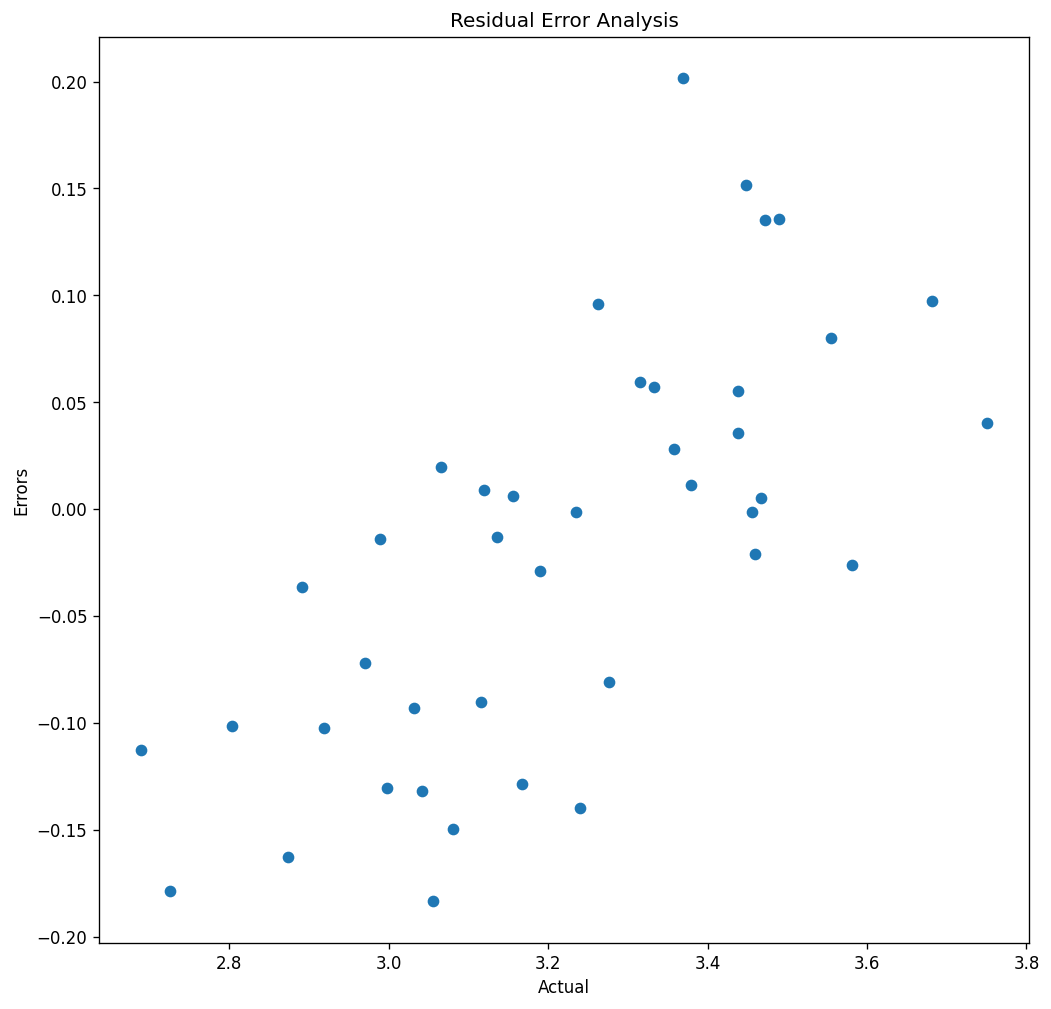

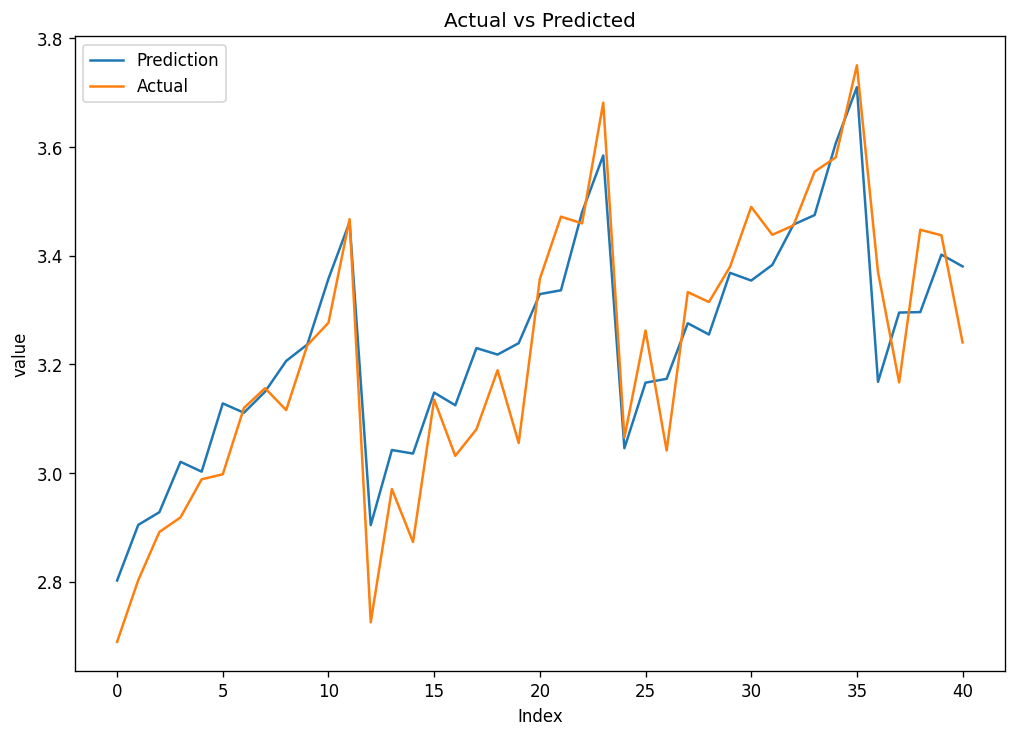

In [116]:
# Get actual values
actuals = test[input_target_variable].reset_index(drop = True)

# Select the algorithm according to the input provided
if input_ts_algo == 'auto_arima':
    
    print("------------- Auto ARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarima':
    
    print("------------- Auto SARIMA --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = True, exogenous_variable = None)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'auto_sarimax':
    
    print("------------- Auto SARIMAX --------------- \n")
    model = model_auto_sarimax(y = train[input_target_variable], seasonality = input_seasonality, seasonal_flag = False, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = train[input_exogenous_variable].values.reshape(-1, 1))
    evaluate_model(actuals, predictions)

elif input_ts_algo == 'manual_sarima':
    
    print("------------- Manual SARIMA --------------- \n")
    model = model_manual_sarima(y = train[input_target_variable], order = input_order, seasonal_order = input_seasonal_order)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)

elif input_ts_algo == 'simple_exponential_smoothing':
    
    print("------------- Simple Exponential Smoothing --------------- \n")
    model = model_simple_exponential_smoothing(y = train[input_target_variable])
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)
    
elif input_ts_algo == 'holt_winters':
    
    print("------------- Holt Winters --------------- \n")
    model = model_holt_winters(y = train[input_target_variable], seasonality = input_seasonality)
    predictions = get_predictions(input_ts_algo, model, train, test, input_target_variable, exogenous_variable = None)
    evaluate_model(actuals, predictions)

If you had transformed the y variable, you need to inverse transform it back and then get the evaluation metric

-------------------------- Inverse transform the actual and predicted values and evaluate the model
------------- Model Evaluations --------------- 

MAPE :  6.742069116372962
MAE  :  1.2498810922008936
RMSE  :  1.544563149528271
R2 Score  :  0.8603167499691683
Durbin Watson Score :  1.9159755013427389


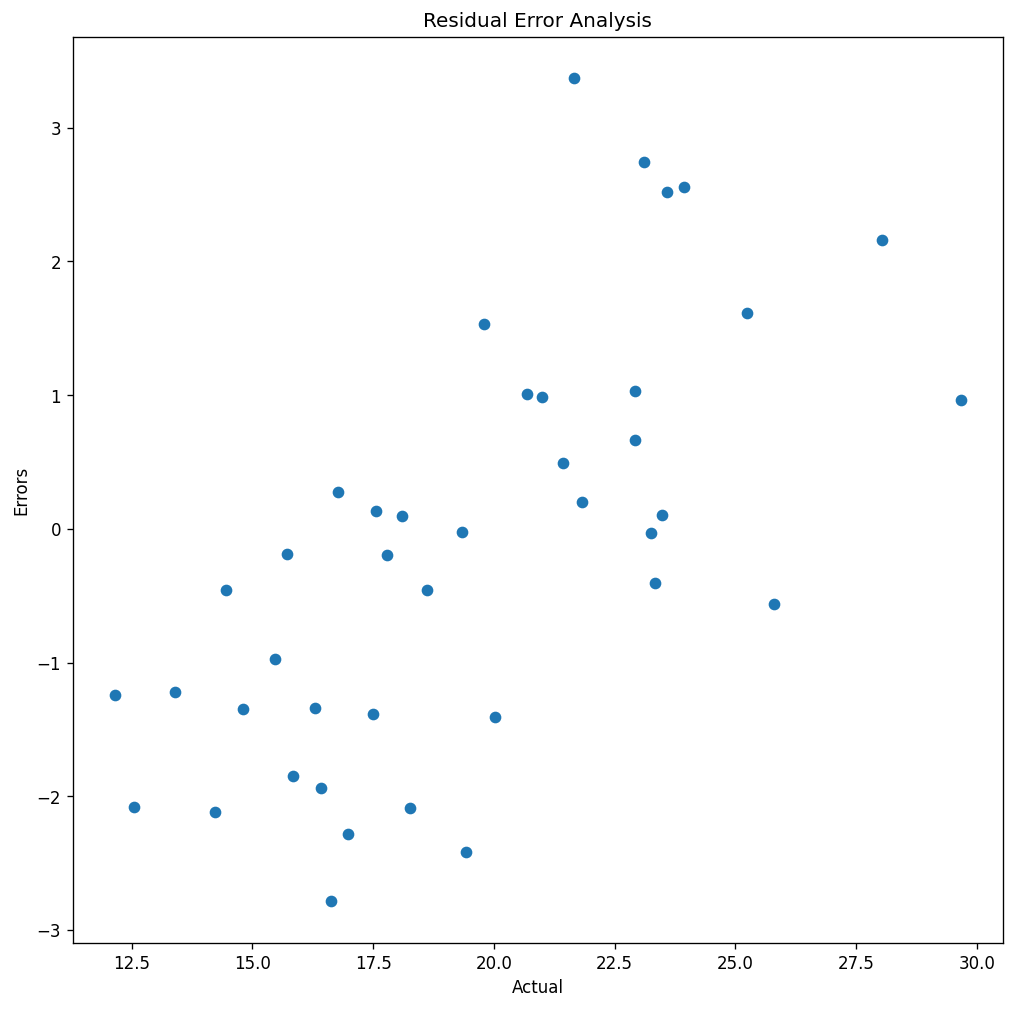

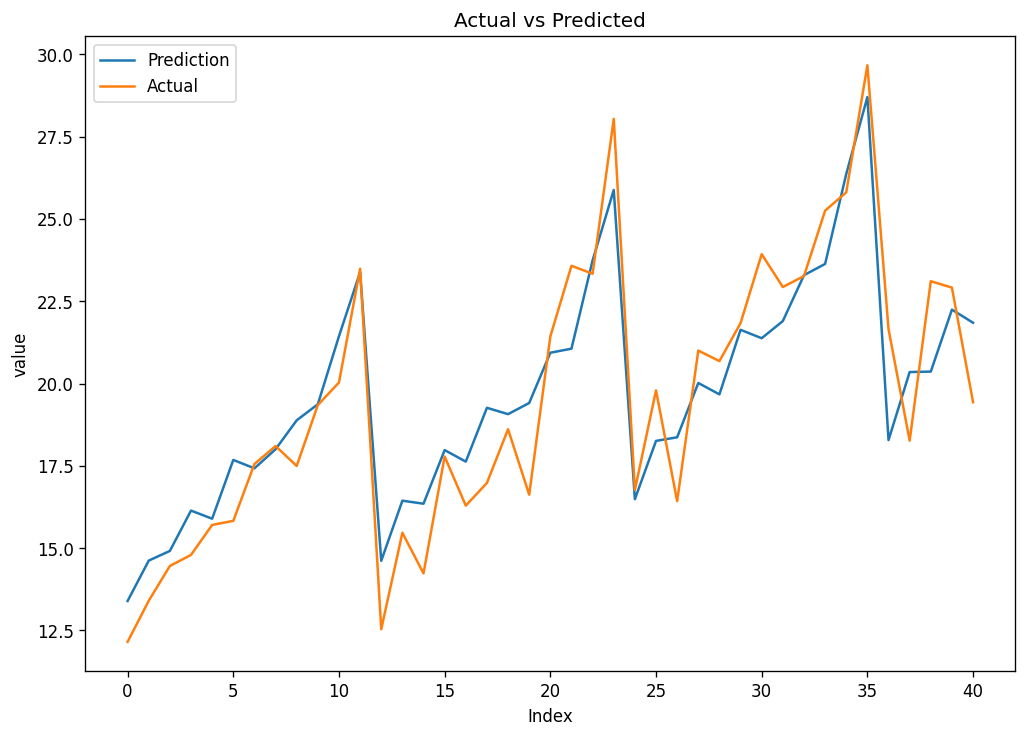

In [117]:
if input_transform_flag == 'Yes':
    print("-------------------------- Inverse transform the actual and predicted values and evaluate the model")
    actuals = inv_boxcox(actuals, lam)
    predictions = inv_boxcox(predictions, lam)
    evaluate_model(actuals, predictions)
else:
    print("No transformation")

### 4.11 Predict model

In [123]:
# Forecast
def predict(model, data, n_periods):
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.plot(data)
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, 
                    lower_series, 
                    upper_series, 
                    color='k', alpha=.15)

    plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
    plt.show()
    return predict

In [132]:
d = pd.Series(df.value)
d.index = df.date

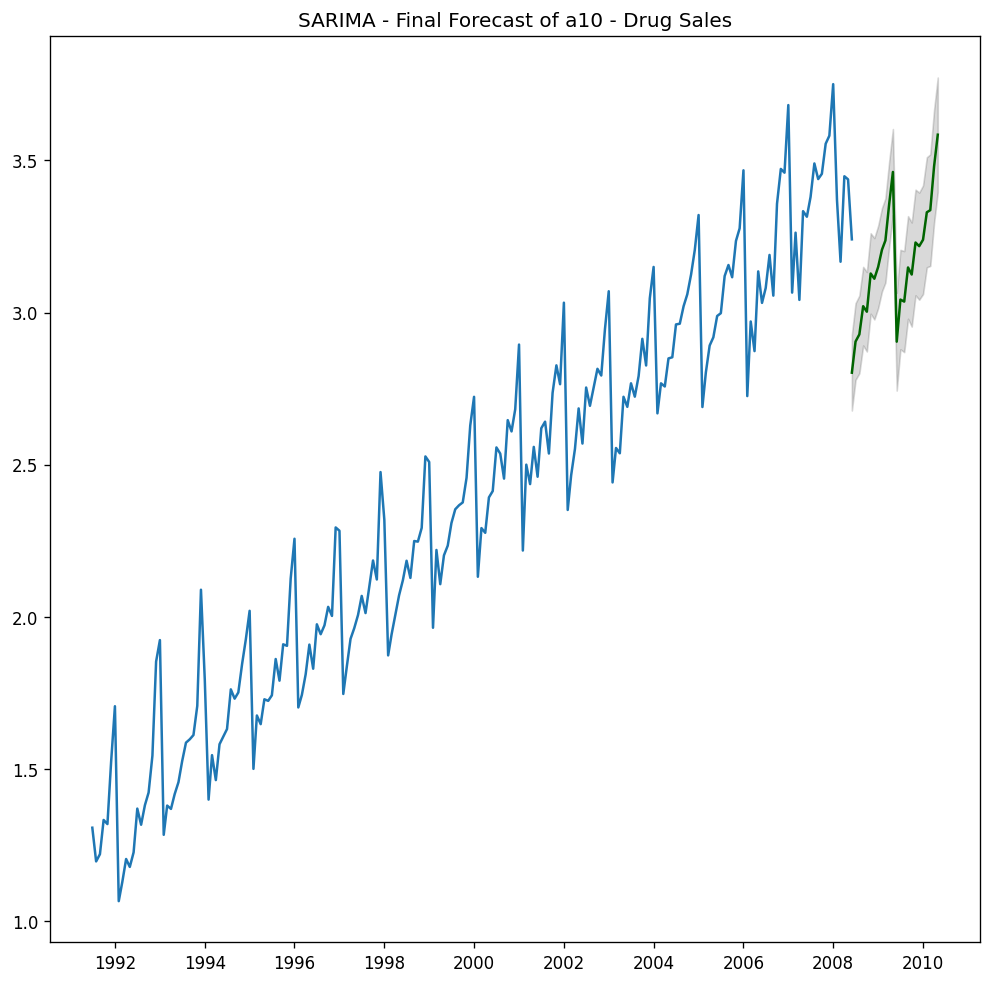

<function __main__.predict>

In [133]:
predict(model, d, 24)

In [120]:
model

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

### 4.11. Save the final model

You can save the model in local disk and use it whenever you want

In [ ]:
# save the model to disk
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 0, 2, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

### 4.12 Linear Regression with feature engineering

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [51]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())
    
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [52]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [53]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')

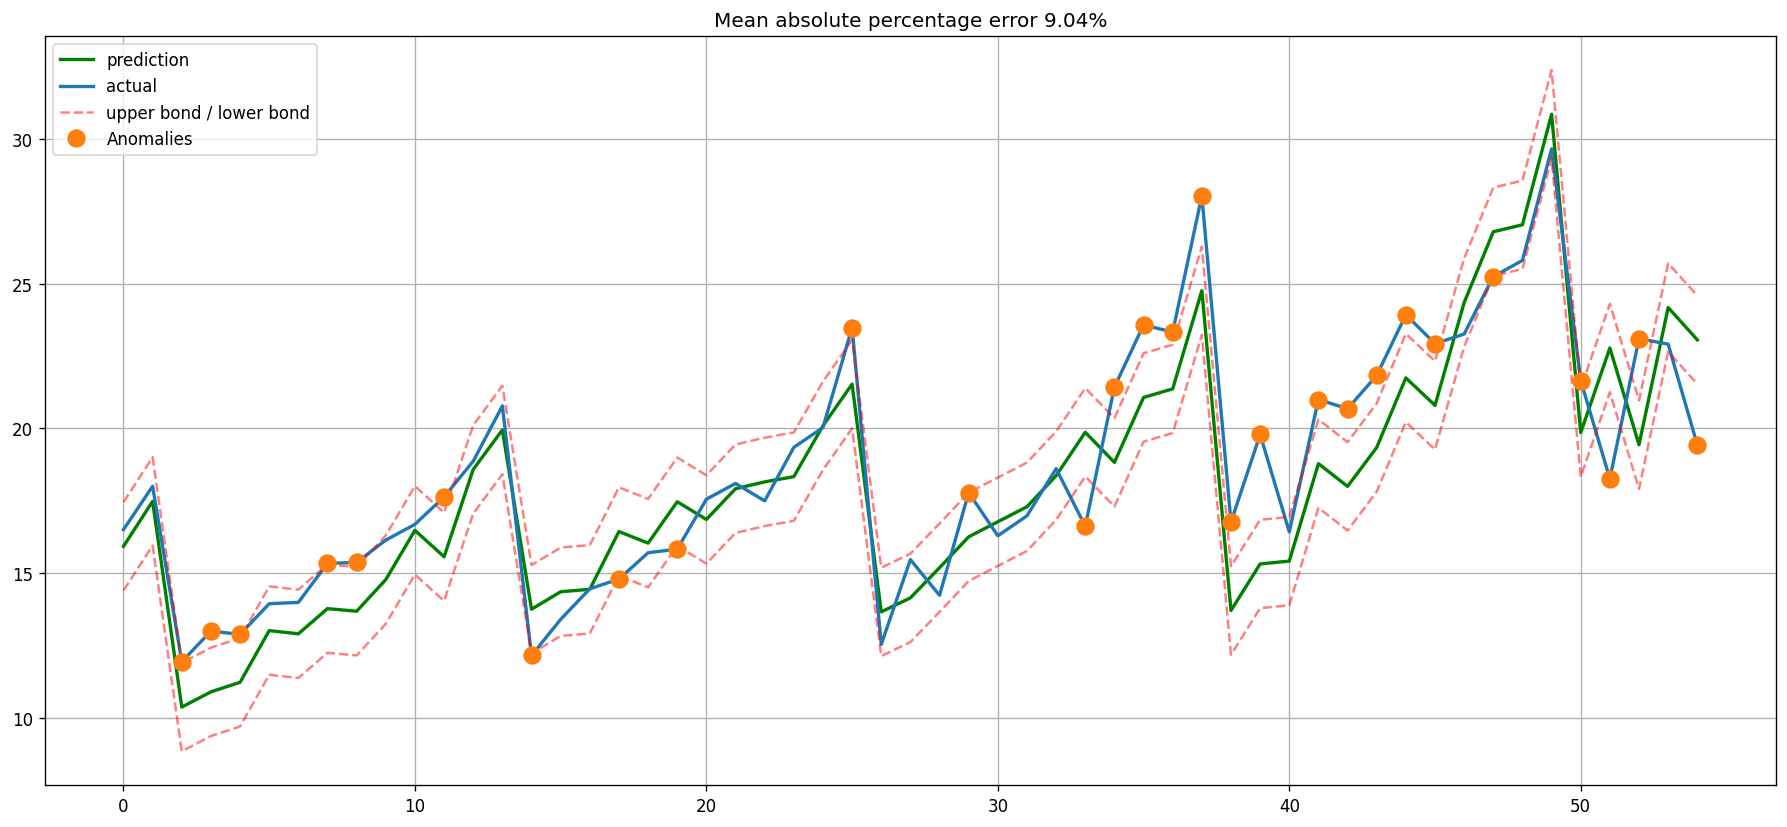

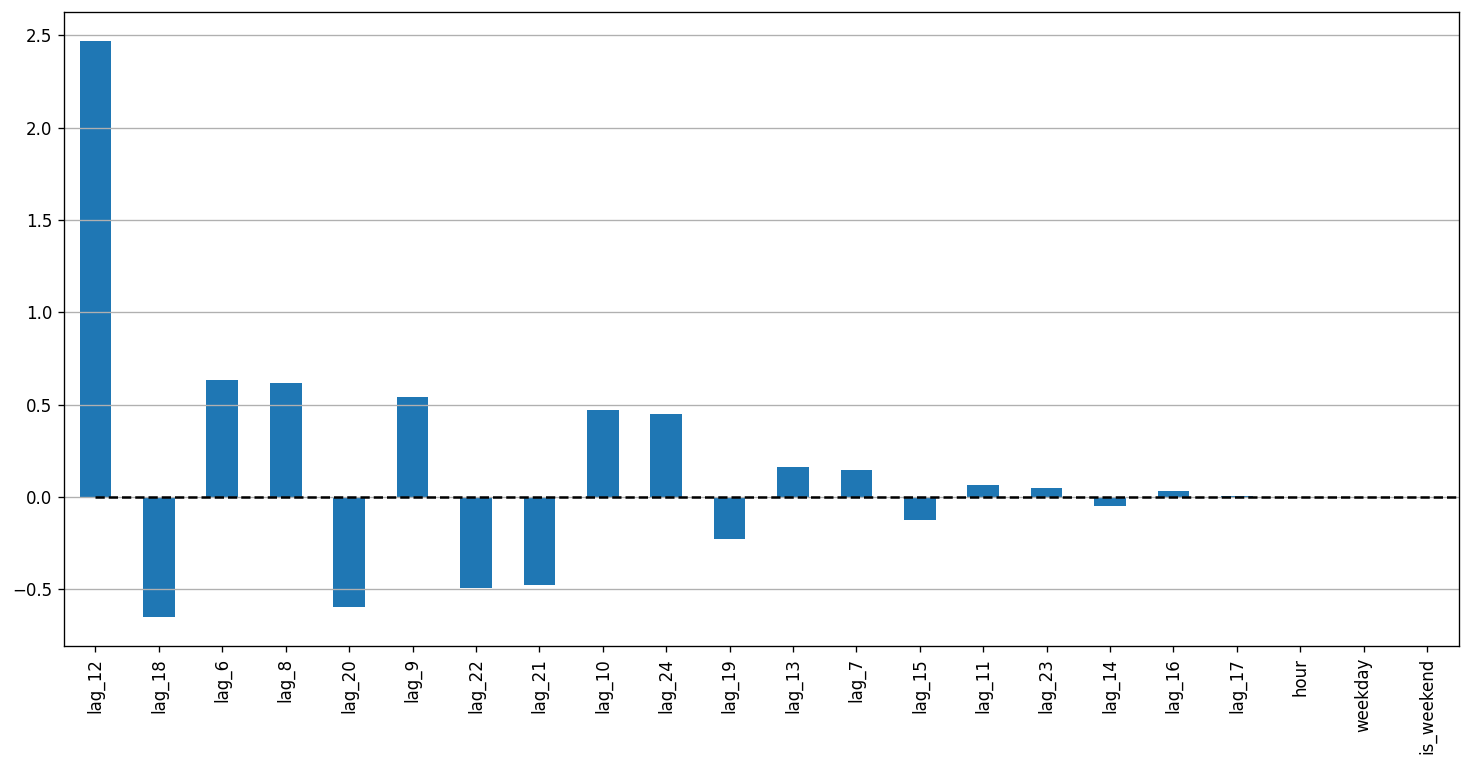

In [54]:
X_train, X_test, y_train, y_test = prepareData(df[input_target_variable], lag_start=6, lag_end=25, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

### 4.13 Granger Causality test to know if one time series is helpful in forecasting another

It accepts a 2D array with 2 columns as the main argument. The values are in the first column and the predictor (X) is in the second column.


The Null hypothesis is: the series in the second column, does not Granger cause the series in the first. If the P-Values are less than a significance level (0.05) then you reject the null hypothesis and conclude that the said lag of X is indeed useful.


The second argument maxlag says till how many lags of Y should be included in the test.

In [59]:
grangercausalitytests(df[['value', 'month_no']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=52.5397 , p=0.0000  , df_denom=200, df_num=1
ssr based chi2 test:   chi2=53.3278 , p=0.0000  , df=1
likelihood ratio test: chi2=47.3499 , p=0.0000  , df=1
parameter F test:         F=52.5397 , p=0.0000  , df_denom=200, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=155.1774, p=0.0000  , df_denom=197, df_num=2
ssr based chi2 test:   chi2=318.2319, p=0.0000  , df=2
likelihood ratio test: chi2=191.0934, p=0.0000  , df=2
parameter F test:         F=155.1774, p=0.0000  , df_denom=197, df_num=2


{1: ({'lrtest': (47.349946285158126, 5.9379745416418535e-12, 1),
   'params_ftest': (52.53966701599241, 8.995154757049917e-12, 200.0, 1.0),
   'ssr_chi2test': (53.32776202123235, 2.8228879721613765e-13, 1),
   'ssr_ftest': (52.539667015992464, 8.995154757049659e-12, 200.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (191.093414718679, 3.195892994937744e-42, 2),
   'params_ftest': (155.1774433004672, 3.4017804703665913e-41, 197.0, 2.0),
   'ssr_chi2test': (318.23191417963864, 7.885293322321595e-70, 2),
   'ssr_ftest': (155.17744330046736, 3.4017804703663997e-41, 197.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

## Prophet library

Prophet assumptions:
* hourly, daily, or weekly observations with at least a few months (preferably a year) of history
* strong multiple “human-scale” seasonalities: day of week and time of year
important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)
* a reasonable number of missing observations or large outliers
* historical trend changes, for instance due to product launches or logging changes
* trends that are non-linear growth curves, where a trend hits a natural limit or saturates

At its core, the Prophet procedure is an additive regression model with four main components:

* A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
* A yearly seasonal component modeled using Fourier series.
* A weekly seasonal component using dummy variables.
* A user-provided list of important holidays.

**Trend**

The Prophet library implements two possible trend models for $g(t)$.

The first one is called *Nonlinear, Saturating Growth*. It is represented in the form of the [logistic growth model](https://en.wikipedia.org/wiki/Logistic_function):

$$g(t) = \frac{C}{1+e^{-k(t - m)}},$$

where:
* $C$ is the carrying capacity (that is the curve's maximum value).
* $k$ is the growth rate (which represents "the steepness" of the curve).
* $m$ is an offset parameter.

This logistic equation allows modelling non-linear growth with saturation, that is when the growth rate of a value decreases with its growth. One of the typical examples would be representing the growth of the audience of an application or a website.

Actually, $C$ and $k$ are not necessarily constants and may vary over time. Prophet supports both automatic and manual tuning of their variability. The library can itself choose optimal points of trend changes by fitting the supplied historical data. 

Also, Prophet allows analysts to manually set changepoints of the growth rate and capacity values at different points in time. For instance, analysts may have insights about dates of past releases that prominently influenced some key product indicators.

The second trend model is a simple *Piecewise Linear Model* with a constant rate of growth. It is best suited for problems without saturating growth.

Seasonality

The seasonal component $s(t)$ provides a flexible model of periodic changes due to weekly and yearly seasonality.

Weekly seasonal data is modeled with dummy variables. Six new variables are added: `monday`, `tuesday`, `wednesday`, `thursday`, `friday`, `saturday`, which take values 0 or 1 depending on the day of the week. The feature `sunday` is not added because it would be a linear combination of the other days of the week, and this fact would have an adverse effect on the model.

Yearly seasonality model in Prophet relies on Fourier series.

Since [version 0.2](https://github.com/facebook/prophet) you can also use *sub-daily time series* and make *sub-daily forecasts* as well as employ the new *daily seasonality* feature.

Holidays and Events

The component $h(t)$ represents predictable abnormal days of the year including those on irregular schedules, e.g., Black Fridays.

To utilize this feature, the analyst needs to provide a custom list of events.

Error

The error term $\epsilon(t)$ represents information that was not reflected in the model. Usually it is modeled as normally distributed noise.

In [143]:
prophet_example = df[['date', 'value']]
prophet_example.columns = ['ds', 'y']
prophet_example.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [144]:
m = Prophet()
m.fit(prophet_example)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [145]:
future = m.make_future_dataframe(periods=100)

In [146]:
forecast = m.predict(future)
forecast.tail(n=3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
301,2008-09-07,3.533557,3.372073,3.523177,3.533404,3.533705,-0.086288,-0.086288,-0.086288,-0.086288,-0.086288,-0.086288,0.0,0.0,0.0,3.447269
302,2008-09-08,3.533954,3.360795,3.519438,3.533795,3.534105,-0.094090,-0.094090,-0.094090,-0.094090,-0.094090,-0.094090,0.0,0.0,0.0,3.439864
303,2008-09-09,3.534351,3.359072,3.517029,3.534188,3.534507,-0.099677,-0.099677,-0.099677,-0.099677,-0.099677,-0.099677,0.0,0.0,0.0,3.434674


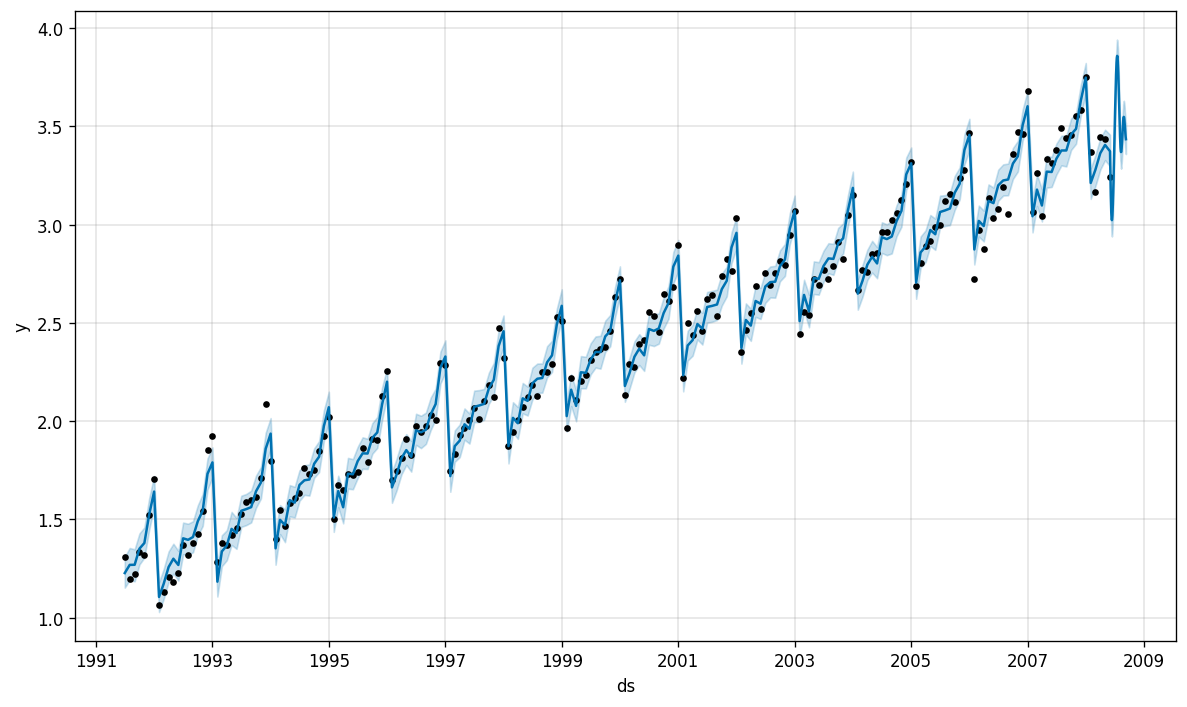

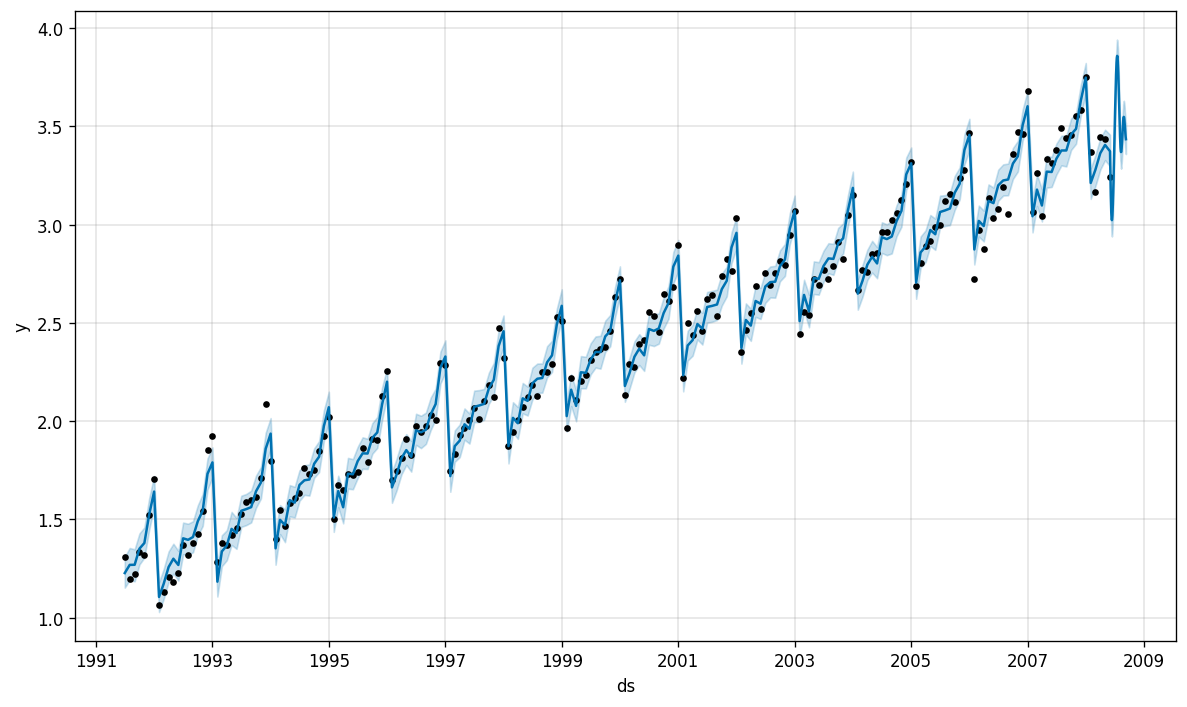

In [147]:
m.plot(forecast)

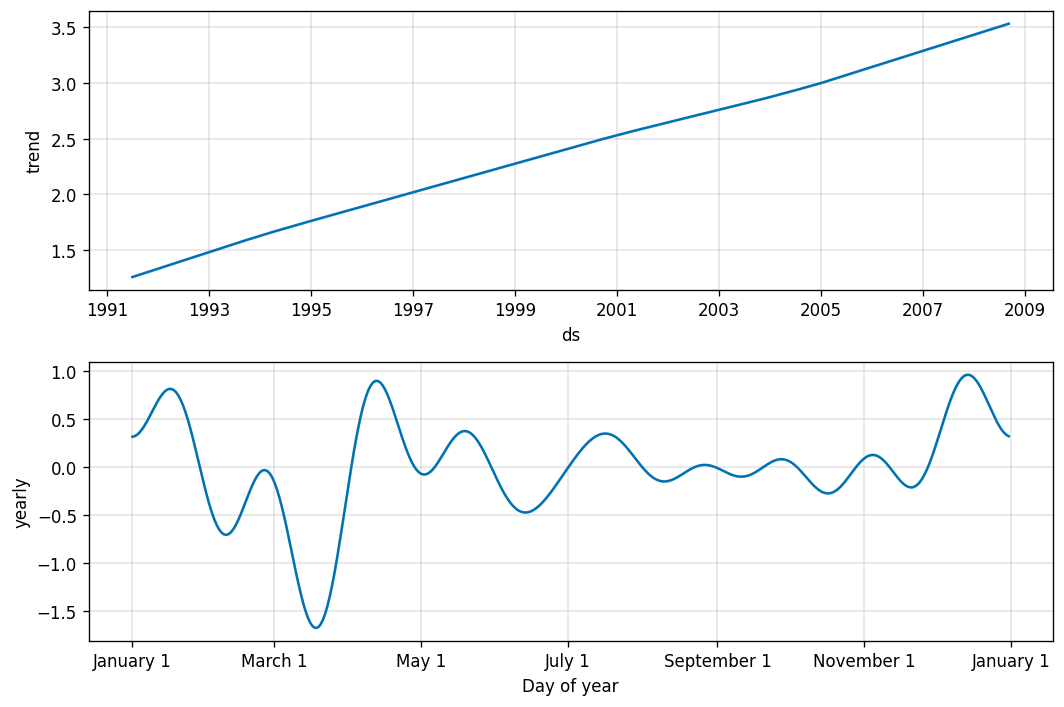

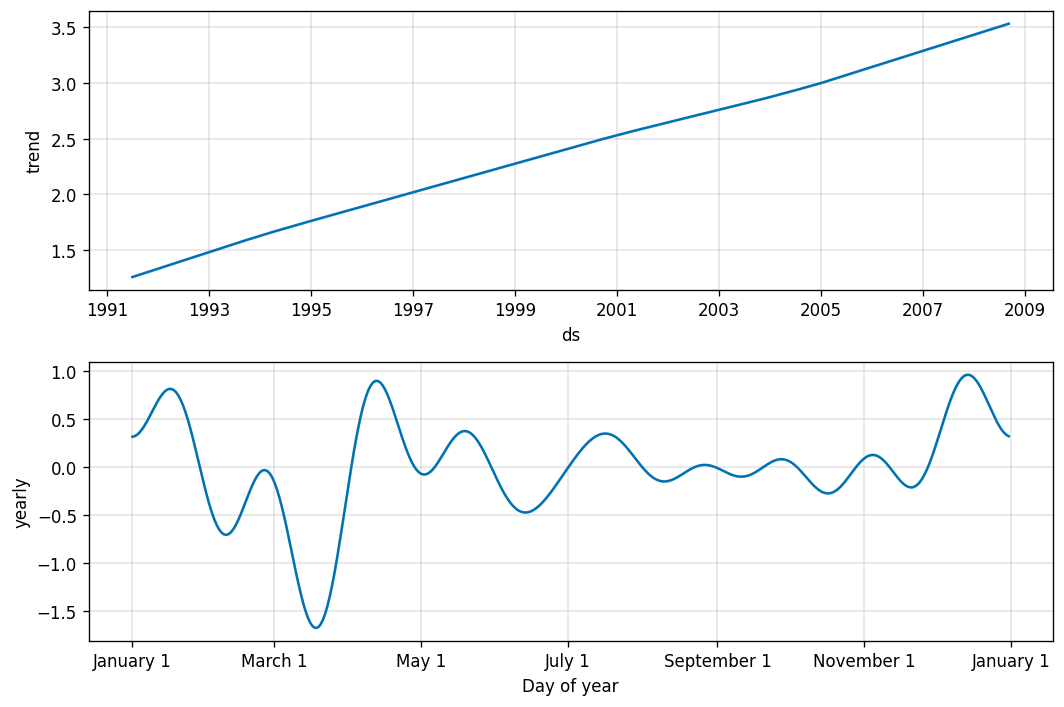

In [149]:
m.plot_components(forecast)

### 5.1. Usefull functions

In [ ]:
def weighted_average(series, weights):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)

